# Metalayer in a transductive setting for Edge betweenness
This notebook shows how a MetaLayer(MPNN) model is trained to compute Ege betweenness on Cora graph

## 1. Edge betweenness training

In [128]:
from __future__ import division

%load_ext autoreload
%autoreload 2


import time
from pprint import pprint
import torch
from torch.nn import *
import os.path as osp
import importlib

import torch
from torch import tensor
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean

import torch_geometric.transforms as T
from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
#from torch_geometric.nn import LinkGCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.nn import MetaLayer

from sklearn.metrics import f1_score

from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:

def get_planetoid_dataset(root,name, normalize_features=False, transform=None):
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Planetoid(root, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset



In [113]:
def scatter_plot_old(preds, targets, 
                 filename='scatterplot.png', 
                 name='scatterplot', 
                 continuous_targets=None,
                 continuous_bins=None,
                 model_id=''):
    newy = np.array(preds.cpu())
    newt = np.array(targets.cpu())
    
    plt.plot(newt, newy,'o', color='black')
    plt.xlabel('target')
    plt.ylabel('prediction');
    plt.plot(newt, newt, color = 'red', linewidth = 2)
    # ranges
    #ax.xlim(0, 1)
    #ax.ylim(0, 1)
    # title
    plt.title(name)
    datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename)
    plt.show()
    
    if continuous_targets is not None and continuous_bins is not None:
        newt = np.array(continuous_targets)
        # translate newy
        newy2 = newy.flatten().tolist()
        for jj in range(len(newy)):
            newy2[jj] = continuous_bins[int(newy2[jj])]
        newy2 = np.array(newy2)
        
        #pprint(newy2)
        #pprint(newt)
        
        plt.plot(newt, newy2,'o', color='black')
        plt.xlabel('target')
        plt.ylabel('prediction');
        plt.plot(newy2, newy2, color = 'red', linewidth = 2)
        # ranges
        #ax.xlim(0, 1)
        #ax.ylim(0, 1)
        # title
        plt.title(name)
        datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename.replace('.png','_real_eb.png'))
        plt.show()
        
def scatter_plot(preds, targets, 
                 filename='scatterplot.png', 
                 name='scatterplot', 
                 continuous_targets=None,
                 continuous_bins=None,
                 model_id=''):
    newy = np.array(preds.cpu())
    newt = np.array(targets.cpu())
    
    plt.plot(newy, newt,'o', color='black')
    plt.ylabel('target')
    plt.xlabel('prediction');
    plt.plot(newt, newt, color = 'red', linewidth = 2)
    # ranges
    #ax.xlim(0, 1)
    #ax.ylim(0, 1)
    # title
    plt.title(name)
    datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename)
    plt.show()
    
    if continuous_targets is not None and continuous_bins is not None:
        newt = np.array(continuous_targets)
        # translate newy
        newy2 = newy.flatten().tolist()
        for jj in range(len(newy)):
            newy2[jj] = continuous_bins[int(newy2[jj])]
        newy2 = np.array(newy2)
        
        #newt2 = newt.flatten().tolist()
        #for jj in range(len(newt)):
        #    newt2[jj] = continuous_bins[int(newt2[jj])]
        #newt2 = np.array(newt2)
        
        #pprint(newy2)
        #pprint(newt)
        
        plt.plot(newy2, newt,'o', color='black')
        plt.ylabel('target')
        plt.xlabel('prediction');
        plt.plot(newt, newt, color = 'red', linewidth = 2)
        # ranges
        #ax.xlim(0, 1)
        #ax.ylim(0, 1)
        # title
        plt.title(name)
        datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename.replace('.png','_real_eb.png'))
        plt.show()
    
def histogram_plot(preds, targets, 
                   filename='histogram.png', 
                   name='histogram', 
                   continuous_targets=None,
                   continuous_bins=None,
                   model_id=''):
    newy = np.array(preds.cpu())
    newt = np.array(targets.cpu())
    
    
    plt.hist(newy, density=True,alpha=0.6, label='prediction')
    plt.hist(newt, density=True, alpha=0.6, label='target')
    # ranges
    #ax.xlim(0, 1)
    #ax.ylim(0, 1)
    # title
    plt.xlabel('classes')
    plt.ylabel('density')
    plt.title(name)
    datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    plt.legend(prop={'size': 10})
    plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename)
    plt.show()
    
    if continuous_targets is not None and continuous_bins is not None:
        newt = np.array(continuous_targets)
        # translate newy
        newy2 = newy.flatten().tolist()
        for jj in range(len(newy)):
            newy2[jj] = continuous_bins[int(newy2[jj])]
        newy2 = np.array(newy2)
        
            
        plt.hist(newy2, density=True,alpha=0.6, label='prediction')
        plt.hist(newt, density=True, alpha=0.6, label='target')
        # ranges
        #ax.xlim(0, 1)
        #ax.ylim(0, 1)
        # title
        plt.xlabel('classes')
        plt.ylabel('counts')
        plt.title(name)
        datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        plt.legend(prop={'size': 10})
        plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename.replace('.png','_real_eb.png'))
        plt.show()
    
def boxplot_plot(preds, targets, 
                 filename='boxplot.png', 
                 name='boxplot', 
                 continuous_targets=None,
                 continuous_bins=None,
                 model_id=''):

    newy = np.array(preds.cpu())
    newt = np.array(targets.cpu())
        
    newy.shape=newt.shape
    plt.boxplot([newt,newy], labels=['target','pred'])
    plt.title(name)
    datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename)
    plt.show()
    
    if continuous_targets is not None and continuous_bins is not None:
        newt = np.array(continuous_targets)
        # translate newy
        newy2 = newy.flatten().tolist()
        for jj in range(len(newy)):
            newy2[jj] = continuous_bins[int(newy2[jj])]
        newy2 = np.array(newy2)
        
        newt.shape=newy2.shape
        plt.boxplot([newt,newy2], labels=['target','pred'])
        plt.title(name)
        datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        plt.savefig('img/'+datetime_str+'_'+model_id+'_'+filename.replace('.png','_real_eb.png'))
        plt.show()

def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, y, num_classes, tr_split=20, val_split=500, test_split=1500):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    #indices = []
    #for i in range(num_classes):
    #    index = (data.y == i).nonzero().view(-1)
    #    index = index[torch.randperm(index.size(0))]
    #    indices.append(index)
    ## changed 20 -> 40, 500->750 
    #train_index = torch.cat([i[:tr_split] for i in indices], dim=0)

    #rest_index = torch.cat([i[tr_split:] for i in indices], dim=0)
    #rest_index = rest_index[torch.randperm(rest_index.size(0))]

    #data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    #data.val_mask = index_to_mask(rest_index[:val_split], size=data.num_nodes)
    #data.test_mask = index_to_mask(rest_index[val_split:test_split], size=data.num_nodes)
    
    # they should be correspondent, so train_edge_mask & co should be derived...
    # too lazy , just remove mask for nodes for now
    
    indices = []
    for i in range(num_classes):
        index = (y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:tr_split] for i in indices], dim=0)

    rest_index = torch.cat([i[tr_split:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]
    
    data.train_edge_mask = index_to_mask(train_index, size=len(y))
    data.val_edge_mask = index_to_mask(rest_index[:val_split], size=len(y))
    data.test_edge_mask = index_to_mask(rest_index[val_split:test_split], size=len(y))

    return data


def train(model, optimizer, data, y):
    model.train()
    optimizer.zero_grad()
    # so the model uses all the nodes and edges
    out = model(data)
    # but only tests loss on masked edges...
    loss = F.nll_loss(out[data.train_edge_mask], y[data.train_edge_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data, y, plots=False, continuous_targets=None,continuous_bins=None,model_id='model', num_classes=10):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        edge_mask = data['{}_edge_mask'.format(key)]
        loss = F.nll_loss(logits[edge_mask], y[edge_mask]).item()
        pred = logits[edge_mask].max(1)[1]
        acc = pred.eq(y[edge_mask]).sum().item() / edge_mask.sum().item()
        if plots:
            # scatter plot
            scatter_plot(pred,y[edge_mask], continuous_targets=continuous_targets[edge_mask], continuous_bins=continuous_bins,model_id=model_id)
            
            # histogram
            histogram_plot(pred,y[edge_mask], continuous_targets=continuous_targets[edge_mask], continuous_bins=continuous_bins,model_id=model_id)
            
            # boxplot
            boxplot_plot(pred,y[edge_mask], continuous_targets=continuous_targets[edge_mask], continuous_bins=continuous_bins,model_id=model_id)
            
        f1macro =  f1_score(y[edge_mask].cpu(), pred.cpu(), average='macro', labels=list(range(num_classes)))  
        
        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc
        outs['{}_f1macro'.format(key)] = f1macro

    return outs




def run(dataset,
        y,
        num_classes,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        tr_mask_length=20, val_mask_length=500, test_mask_length=1500,
        logger=None,
        results_file='GN_exp1_semisuperv.csv',
        continuous_targets=None,
        continuous_bins=True):
    
    print("RUn ",str(model))
    pprint(y)
    model_params= str(model)+'_r='+str(runs)+'_epochs='+str(epochs)+'_split-'+str(tr_mask_length)+'-'+str(val_mask_length)+'-'+str(test_mask_length)+'-'
    model_id = str(model.__class__.__name__)+model_params

    val_losses, accs, durations, f1s = [], [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data,y, num_classes,
                                 tr_split=tr_mask_length,
                                 val_split=val_mask_length, 
                                 test_split=test_mask_length)
        data = data.to(device)
        y = y.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        test_f1m =  0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data, y)
            eval_info = evaluate(model, data, y, num_classes=num_classes)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']
                test_f1m = eval_info['test_f1macro']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    if _ == runs-1:
                        eval_info = evaluate(
                            model, 
                            data, 
                            y, 
                            plots=True, 
                            continuous_targets=continuous_targets,
                            continuous_bins=continuous_bins,
                            model_id=model_id,
                        )
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        f1s.append(test_f1m)
        durations.append(t_end - t_start)
        
        
            
        
        

    loss, acc, duration, f1 = tensor(val_losses), tensor(accs), tensor(durations), tensor(f1s)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Test F1-macro: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 f1.mean().item(),
                 f1.std().item(),
                 duration.mean().item()))
    with open(results_file,'a') as f:
        f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f} ± {:.3f}, {:.3f}\n'.
          format(
                 model.__class__.__name__, 
                 model_params,
                 loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 f1.mean().item(),
                 f1.std().item(),
                 duration.mean().item()))
            

In [131]:
class EdgeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges, hidden_units=10,out_units=10):
        super(EdgeModel, self).__init__()
        #self.edge_mlp = Seq(Lin(2 * 10 + 5 + 20, 5), ReLU(), Lin(5, 5))
        self.edge_mlp = Seq(
            Lin(2*num_features + num_edge_features +1 ,hidden_units), 
            ReLU(), 
            Lin(hidden_units, out_units))

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #print(src.shape, dest.shape, edge_attr.shape, u[batch].shape)
        out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self,
                 num_edge_features, num_features, num_edges,
                 hidden_units=10,out_units_edge=10, 
                 out_units_node1=10, out_units_node2=10):  
        super(NodeModel, self).__init__()
        #self.node_mlp_1 = Seq(Lin(15, 10), ReLU(), Lin(10, 10))
        
        self.node_mlp_1 = Seq(
            Lin(num_features+out_units_edge, hidden_units), 
            ReLU(), 
            Lin(hidden_units, out_units_node1))
        #self.node_mlp_2 = Seq(Lin(2 * 10 + 20, 10), ReLU(), Lin(10, 10))
        self.node_mlp_2 = Seq(
            Lin(num_features+1+out_units_node1, hidden_units), 
            ReLU(), 
            Lin(hidden_units, out_units_node2))


    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp_2(out)

class GlobalModel(torch.nn.Module):
    def __init__(self,hidden_units):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(2*hidden_units + hidden_units, 2*hidden_units), ReLU(), Lin(2*hidden_units, hidden_units))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([u, scatter_mean(x, batch, dim=0)], dim=1)
        #return self.global_mlp(out)
        return u

    
class META1(torch.nn.Module):
    def __init__(self, 
                 num_classes=5, 
                 num_edge_features=1, 
                 num_features=1433, 
                 num_edges=6,
                 edge_attr=None, 
                 d4 =19,d5=16,
                 hidden_units=10,
                 out_units_edge=19,
                 out_units_node1=16,
                 out_units_node2=15,
                 ):
        super(META1, self).__init__()

        self.op = MetaLayer(
            EdgeModel(num_edge_features,num_features, num_edges,hidden_units,out_units_edge), 
            NodeModel(num_edge_features, num_features, num_edges,
                      hidden_units,out_units_edge, 
                      out_units_node1, out_units_node2),  
            GlobalModel(hidden_units))
        self.fc1 = nn.Linear(d4, d5)
        self.dense1_bn = nn.BatchNorm1d(d5)
        self.fc2 = nn.Linear(d5, num_classes) 
        self.dense2_bn = nn.BatchNorm1d(num_classes)
        self.edge_attr = edge_attr.to(device)
        self.num_edges = num_edges
        self.d4=d4
        self.d5=d5
        self.hidden_units=hidden_units
        self.out_units_edge=out_units_edge
        self.out_units_node1=out_units_node1
        self.out_units_node2=out_units_node2
        
    def __str__(self,):
        params='_d4='+str(self.d4) +\
               '_d5='+str(self.d5) +\
                '_hus='+str(self.hidden_units) +\
                '_eus='+str(self.out_units_edge) +\
                '_n1us='+str(self.out_units_node1) +\
                '_n2us='+str(self.out_units_node2)
        
        return params
    
    def reset_parameters(self):
        self.op.reset_parameters()
        #self.conv2.reset_parameters()

    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        x, edge_index, edge_attr,  batch = data.x, data.edge_index, self.edge_attr,  torch.tensor([0] * len(data.x))        
        #batch must say for each row, which graph it belongs to
        # since only one graph is trained here -> all 0s with length of data.x

        x2, edge_attr2, u2 =  self.op(x, edge_index, edge_attr, torch.ones(1,1).to(device), batch.to(device))
        #x = torch.cat([x2,edge_attr2])
        x = edge_attr2
        #print("after metalayer",x.shape)

        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

class META2(torch.nn.Module):
    def __init__(self, 
                 num_classes=5, 
                 num_edge_features=1, 
                 num_features=1433,
                 num_edges=6,
                 edge_attr=None, 
                 d4=10,d5=10,
                 hidden_units=10,
                 out_units_edge=10,
                 out_units_node1=10,
                 out_units_node2=10,
                 ):
        super(META2, self).__init__()

        self.op = MetaLayer(
            EdgeModel(num_edge_features,num_features, num_edges,hidden_units,out_units_edge),
            NodeModel(num_edge_features, num_features, num_edges,
                      hidden_units,out_units_edge, 
                      out_units_node1, out_units_node2),  
            GlobalModel(hidden_units))
        self.fc1 = nn.Linear(d4, d5)
        self.dense1_bn = nn.BatchNorm1d(d5)
        self.fc2 = nn.Linear(d5, num_classes) 
        self.dense2_bn = nn.BatchNorm1d(num_classes)
        self.edge_attr = edge_attr.to(device)
        self.num_edges = num_edges
        self.d4=d4
        self.d5=d5
        self.hidden_units=hidden_units
        self.out_units_edge=out_units_edge
        self.out_units_node1=out_units_node1
        self.out_units_node2=out_units_node2
    
    def __str__(self,):
        params='_d4='+str(self.d4) +\
               '_d5='+str(self.d5) +\
                '_hus='+str(self.hidden_units) +\
                '_eus='+str(self.out_units_edge) +\
                '_n1us='+str(self.out_units_node1) +\
                '_n2us='+str(self.out_units_node2) 
        
        return params
    
    
    
    def reset_parameters(self):
        self.op.reset_parameters()
        #self.conv2.reset_parameters()

    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        x, edge_index, edge_attr,  batch = data.x, data.edge_index, self.edge_attr,  torch.tensor([0] * len(data.x))        
        #batch must say for each row, which graph it belongs to
        # since only one graph is trained here -> all 0s with length of data.x

        x2, edge_attr2, u2 =  self.op(x, edge_index, edge_attr, torch.ones(1,1).to(device), batch.to(device))
        #x = torch.cat([x2,edge_attr2])
        x = edge_attr2
        #print("after metalayer",x.shape)

        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

In [115]:
def dataset_preprocessing(data, num_bins=None, num_features=1):
    # get dataset, see data.y is classess
    data
    #data.y

    # transform to nx
    #g = pyTorchGeometricDatasetToNx(data)
    g = pytorch_geometric_dataset_to_Nx2(data)

    # compute node betweenness
    eb = nx.edge_betweenness_centrality(g,normalized=True)
    
    # generate edge_target_attr's from eb dict
    data.edge_attr = torch.zeros(len(data.edge_index[0]),1)
    data.y = torch.ones(len(data.edge_index[0]),1)
    for j in range(len(data.edge_index[0])):
        t = (data.edge_index[0][j].item(), data.edge_index[1][j].item()) 
        t2 = (data.edge_index[1][j].item(), data.edge_index[0][j].item())

        if t in eb.keys():
            #print(t, eb[t])
            data.y[j]=eb[t]

        elif t2 in eb.keys():
            #print(t2, eb[t2])
            data.y[j]=eb[t2]
        else:
            # if edge was redundant it may not be captured by nx
            # but since it appeared in the original dataset we add it with value 0
            eb[t]=0.0
            #print(t, eb[t])
            data.y[j]=eb[t]

        #print(t,t2,data.edge_attr[j])
        #print(data.y[j])
        #print()

    data.y = data.y.reshape(-1,1)
    data.x = data.x.reshape(-1,1)
    data.y = data.y.float()
    data.y = torch.FloatTensor(data.y)
    data.edge_attr = data.edge_attr.float()
    
    print(data.y.max())
    
    # auto-iteration would be great...
    if num_bins is None:
        num_bins=20
    thebins=pd.qcut(data.y.flatten(),num_bins)
    binlimits = []
    for interval in thebins.categories:
        binlimits.append(interval.left)
    bins = np.array(binlimits )

    pprint(bins)
    y_discrete= np.digitize(data.y.numpy(), bins)
    print(y_discrete)
    plt.hist(y_discrete)
    plt.show()
    
    # discretize target edge_betweenness
    y_discrete = y_discrete.flatten()
    
    #y_list = y_discrete.tolist()
    #for j in range(len(y_list)):
    #    if y_list[j] == 3:
    #        y_list[j]=0
    #    elif y_list[j] == 4:
    #        y_list[j]=1
    #    elif y_list[j] == 5:
    #        y_list[j]=2
    #    elif y_list[j] == 6:
    #        y_list[j]=3
    #    elif y_list[j] == 7:
    #        y_list[j]=4
    #    elif y_list[j] == 8:
    #        y_list[j]=5#

    #y_discrete = np.array(y_list)
    all_classes = list(set(list(y_discrete.tolist())))
    print("num_classes=",len(all_classes),"\n",all_classes)
    
    num_features = num_features
    num_classes = len(all_classes)
    num_edges = len(data.edge_index[0])
    num_edge_features = 1
    
    data.undiscretize = binlimits
    
    return data, torch.LongTensor(y_discrete), num_features, num_classes, num_edges, num_edge_features

    

In [110]:
#dataset1 = TUDataset(root='temp/'+thename, name='REDDIT-BINARY')
dataset = get_planetoid_dataset(root='temp/planetoid',name='Cora', normalize_features=True)
#inspectGraphDataset(dataset, thename)

## Bin numbers tests 2

In [132]:
def bin_num_test2(dataset, n=10, epochs=20,d4 =19,d5=16,
            hidden_units=10,
            out_units_edge=19,
            out_units_node1=16,
            out_units_node2=15,
            tr_mask_length=20, val_mask_length=500, test_mask_length=1500,
            results_file='GN_exp1_semisuperv.csv'):
    
    data, y_discrete, num_features, num_classes, num_edges, num_edge_features = dataset_preprocessing(
        dataset[0], 
        num_features=dataset.num_features,
       # thebins=[0.0, 1e-10000000, 2e-7, 2e-4,5e-4, 7e-4, 15e-4, 0.01,0.02,0.03 v]
        num_bins=n
    )
    
    
    print(data.undiscretize)
    permute_masks = random_planetoid_splits 
    num_features = 1
    num_classes = n
    run(dataset,
        y_discrete, 
        num_classes, 
        META1( 
            num_classes=num_classes,
            num_edge_features=1, # for eache edge only 1 feature
            num_features=dataset.num_features, 
            edge_attr = torch.FloatTensor(data.edge_attr), 
            num_edges=len(data.edge_attr),
            d4 =19,d5=16,
            hidden_units=10,
            out_units_edge=19,
            out_units_node1=16,
            out_units_node2=15,
        ), 
        100, # runs 
        epochs, # epochs
        0.01,  # lr
        0.0005, #wd
        10, permute_masks,
        tr_mask_length=tr_mask_length, val_mask_length=val_mask_length, test_mask_length=test_mask_length,
        results_file=results_file,
        continuous_targets=data.y,
        continuous_bins=data.undiscretize)

# Original

tensor(0.0359)
array([-9.99727e-04,  7.05000e-07,  1.49000e-05,  6.51000e-05,
        1.32000e-04,  1.96000e-04,  2.71000e-04,  3.39000e-04,
        4.25000e-04,  5.08000e-04,  5.88000e-04,  6.71000e-04,
        6.78000e-04,  6.98000e-04,  8.32000e-04,  1.02000e-03,
        1.29000e-03,  1.58000e-03,  2.18000e-03,  3.53000e-03])
[[ 6]
 [ 6]
 [ 5]
 ...
 [15]
 [ 1]
 [ 5]]


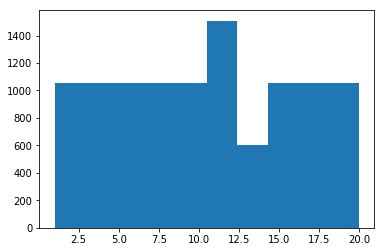

num_classes= 20 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[-0.000999727, 7.05e-07, 1.49e-05, 6.51e-05, 0.000132, 0.000196, 0.000271, 0.000339, 0.000425, 0.000508, 0.000588, 0.000671, 0.000678, 0.000698, 0.000832, 0.00102, 0.00129, 0.00158, 0.00218, 0.00353]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 6,  6,  5,  ..., 15,  1,  5])


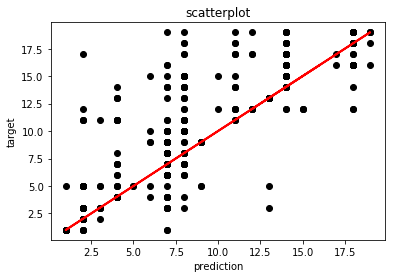

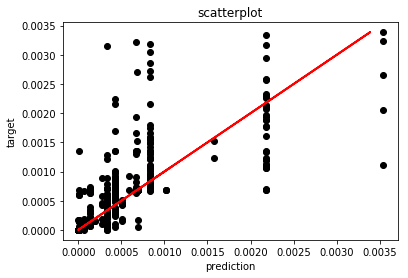

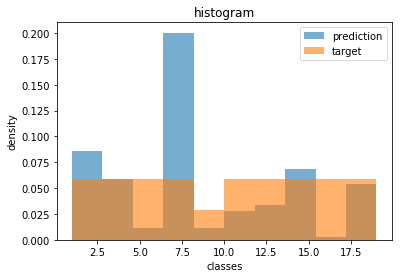

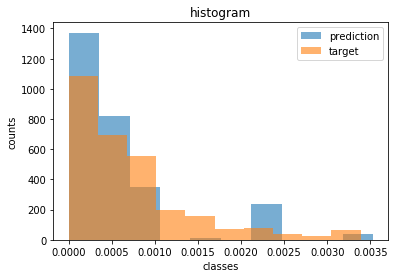

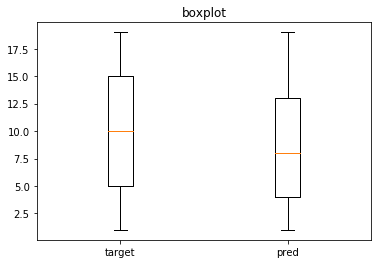

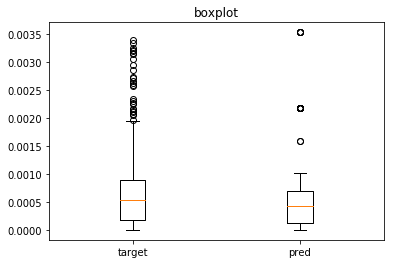

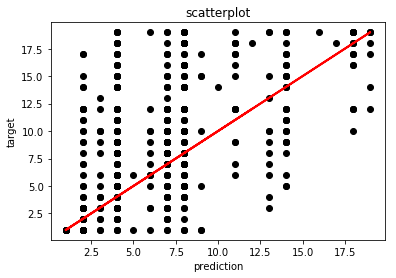

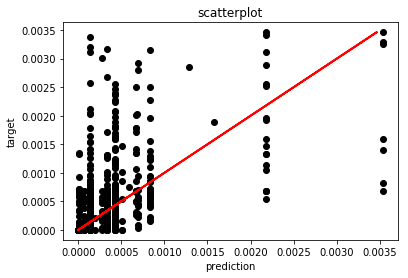

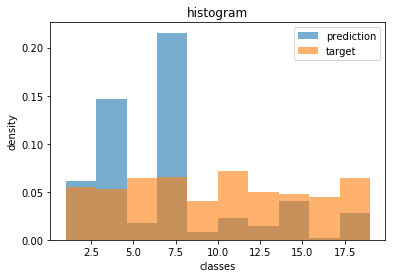

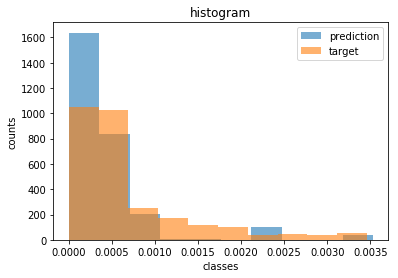

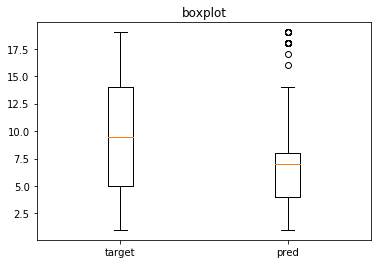

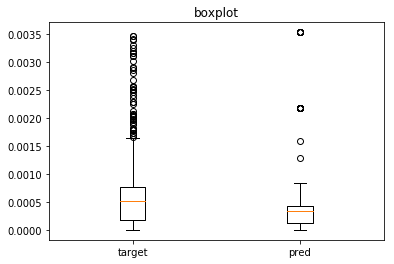

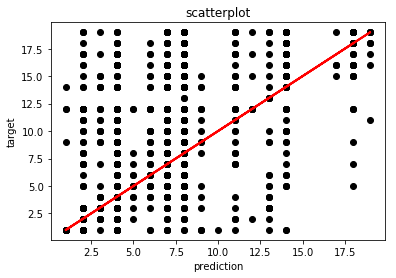

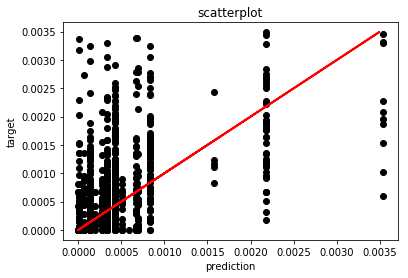

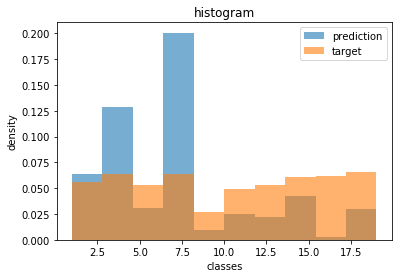

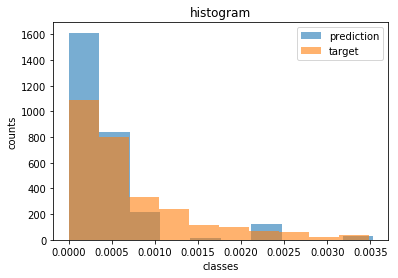

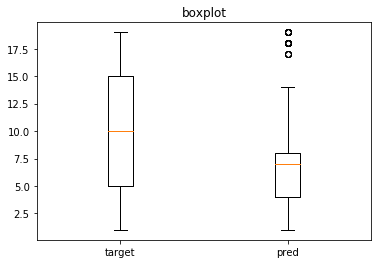

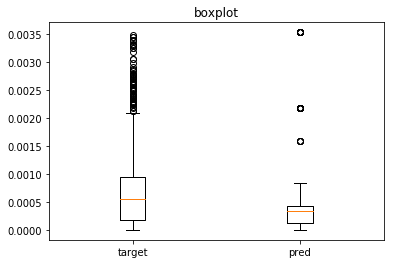

Val Loss: 2.8104, Test Accuracy: 0.138 ± 0.022, Duration: 0.480


In [8]:
bin_num_test2(dataset, n=20, epochs=20, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.99727e-04,  1.49000e-05,  1.32000e-04,  2.71000e-04,
        4.25000e-04,  5.88000e-04,  6.78000e-04,  8.32000e-04,
        1.29000e-03,  2.18000e-03])
[[3]
 [3]
 [3]
 ...
 [8]
 [1]
 [3]]


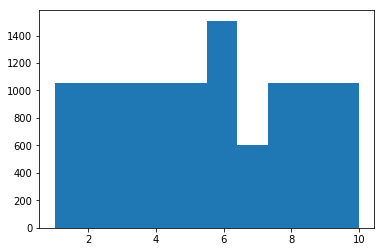

num_classes= 10 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[-0.000999727, 1.49e-05, 0.000132, 0.000271, 0.000425, 0.000588, 0.000678, 0.000832, 0.00129, 0.00218]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([3, 3, 3,  ..., 8, 1, 3])


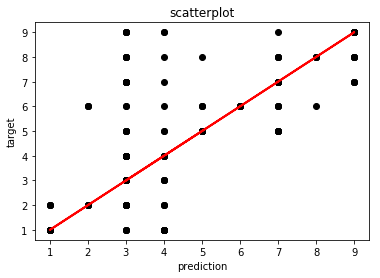

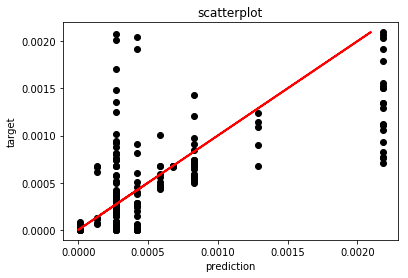

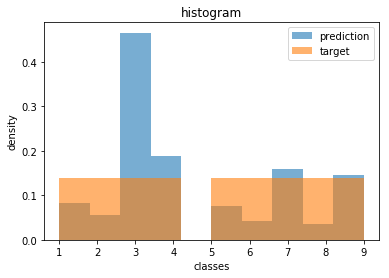

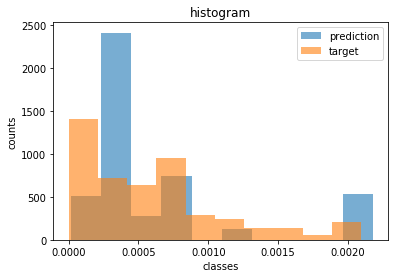

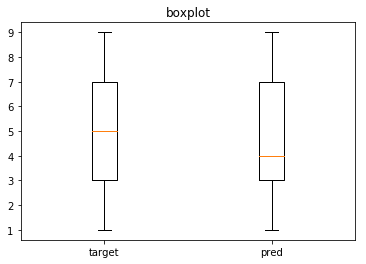

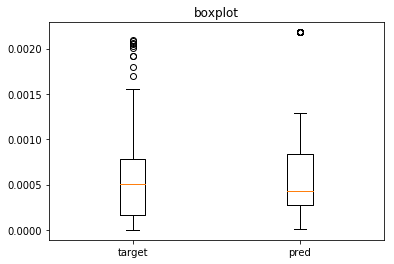

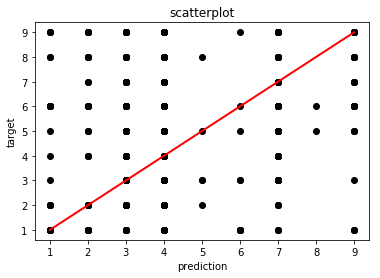

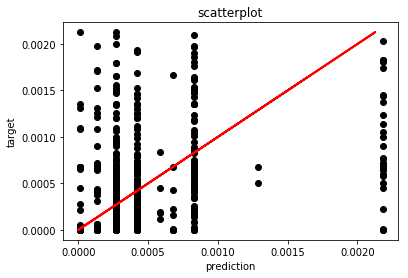

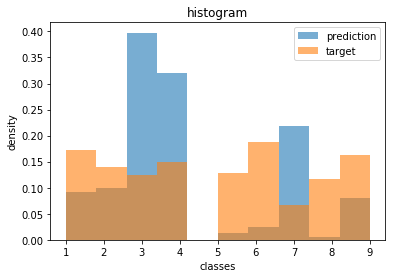

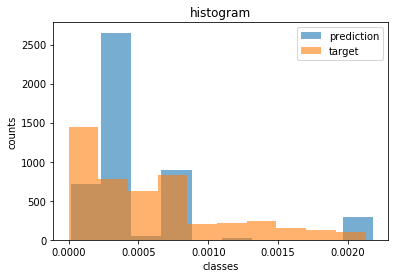

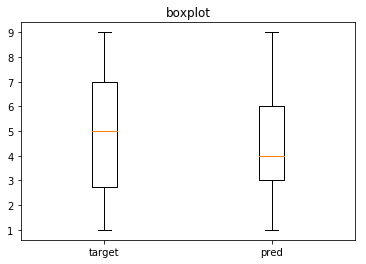

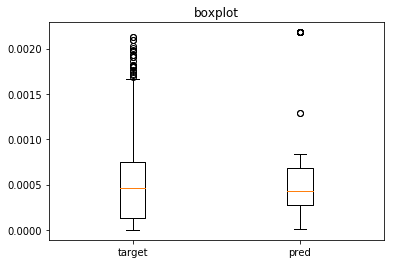

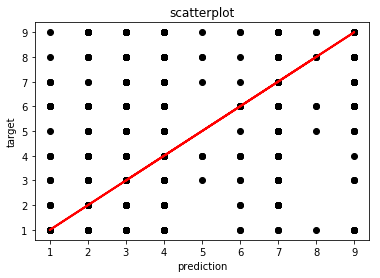

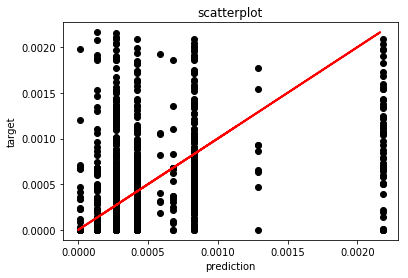

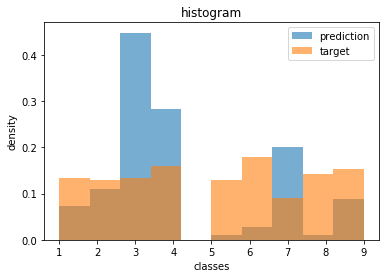

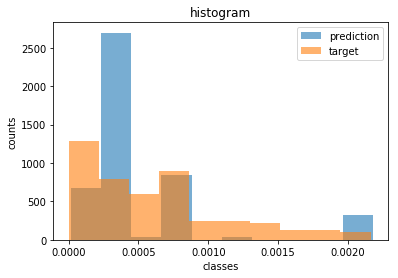

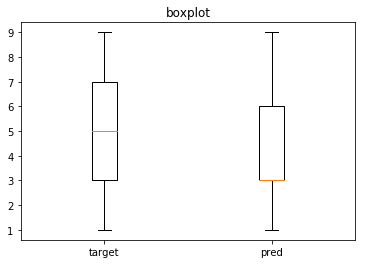

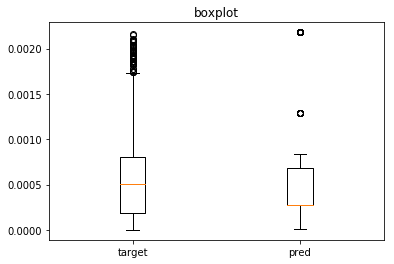

Val Loss: 2.3182, Test Accuracy: 0.204 ± 0.024, Duration: 0.522


In [11]:
bin_num_test2(dataset, n=10, epochs=20, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


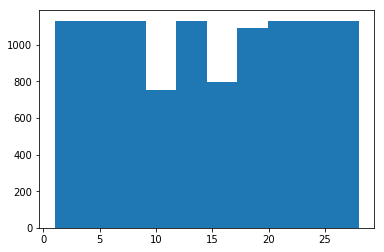

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


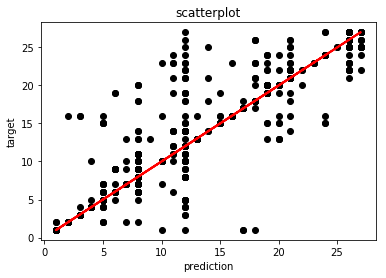

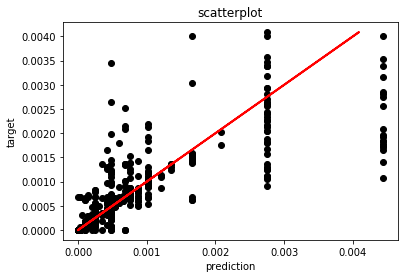

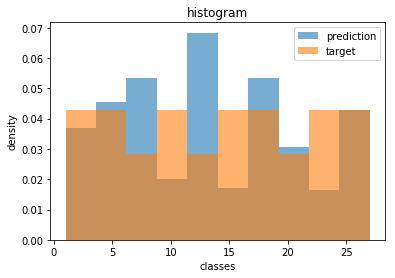

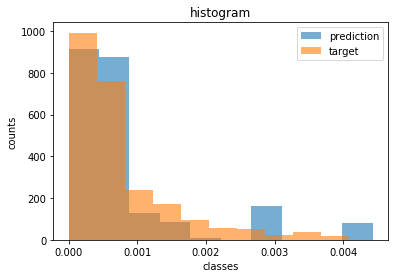

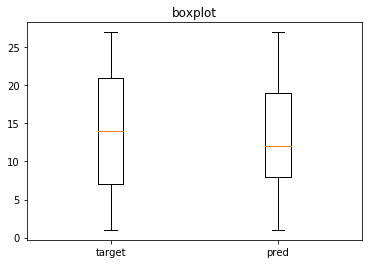

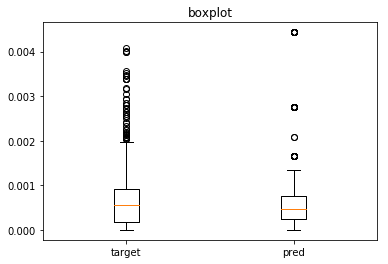

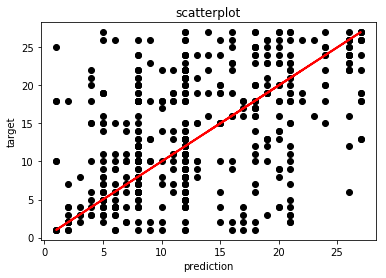

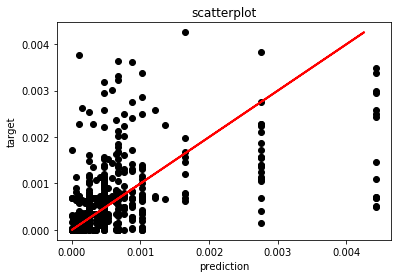

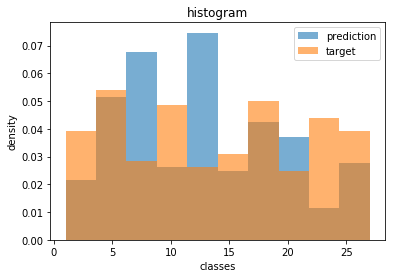

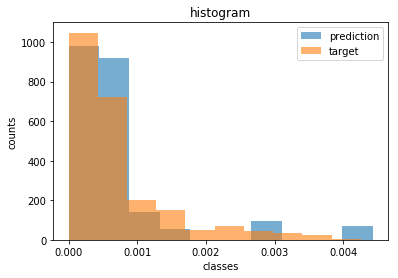

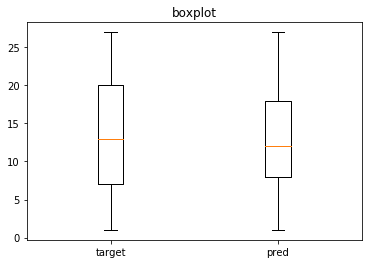

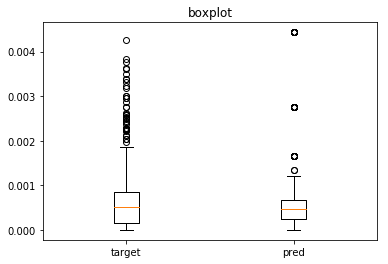

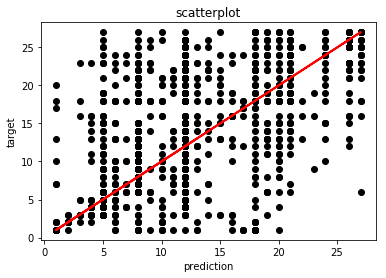

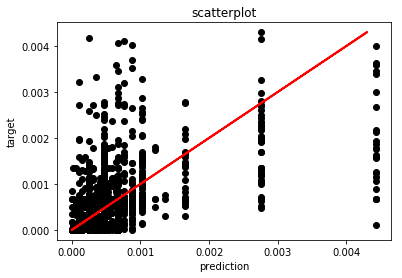

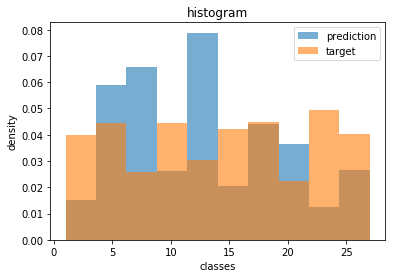

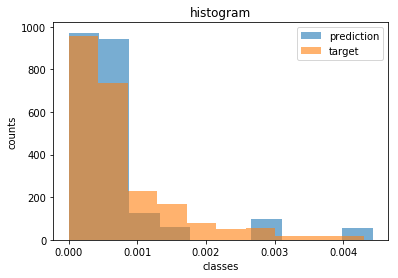

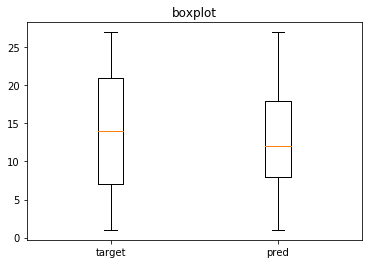

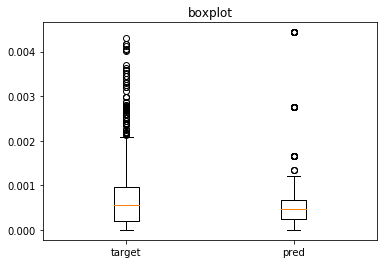

Val Loss: 3.0321, Test Accuracy: 0.136 ± 0.022, Duration: 0.512


In [12]:
bin_num_test2(dataset, n=28, epochs=20, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


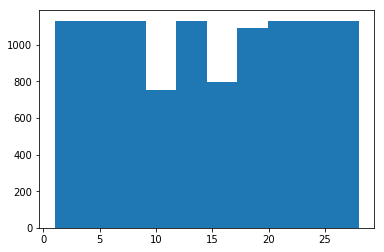

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


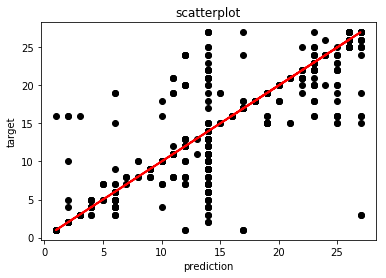

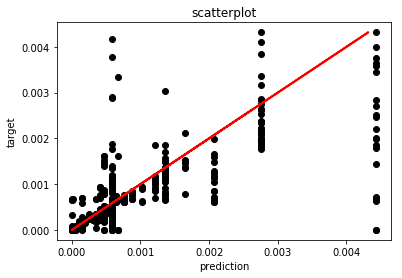

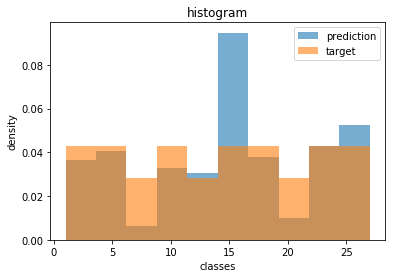

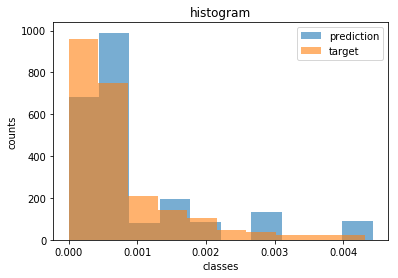

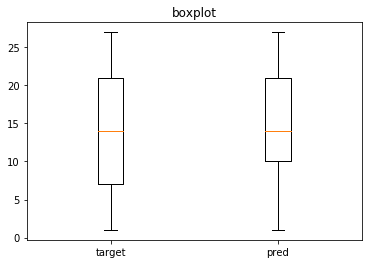

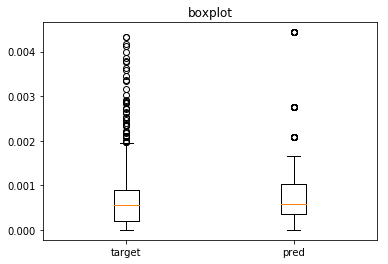

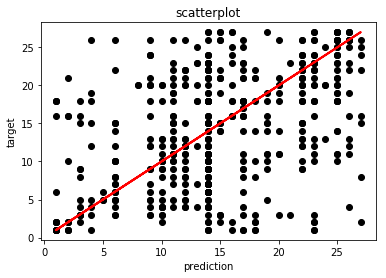

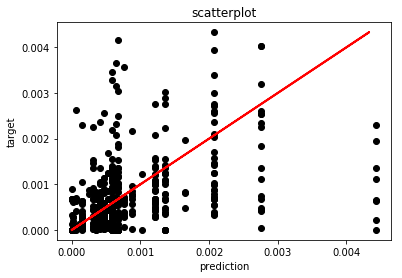

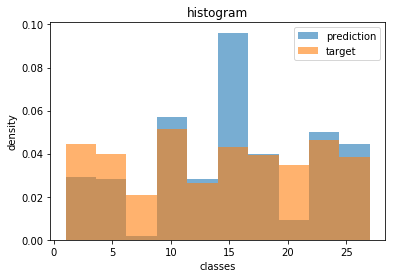

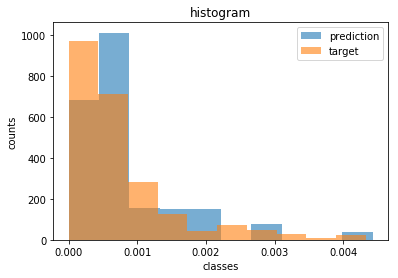

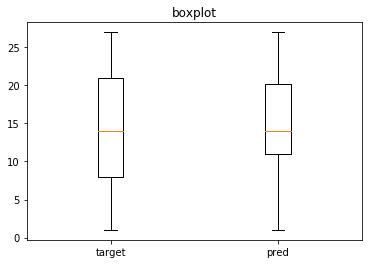

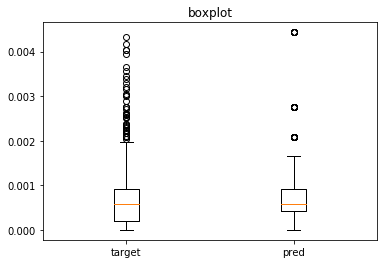

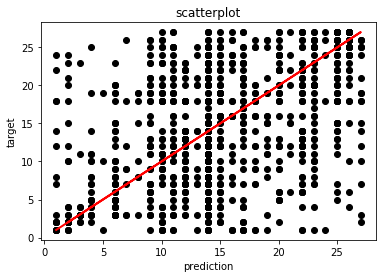

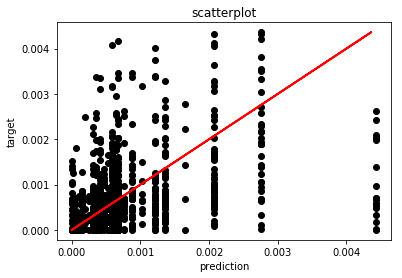

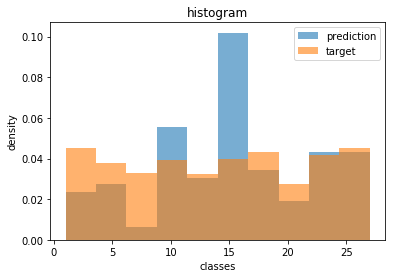

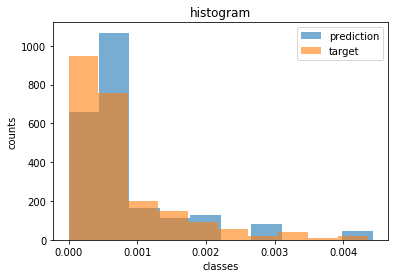

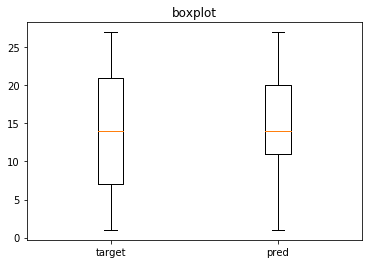

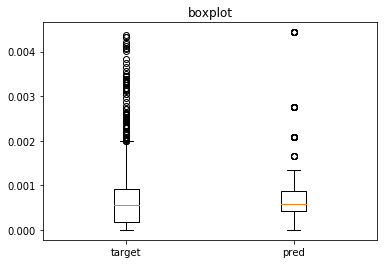

Val Loss: 3.3168, Test Accuracy: 0.116 ± 0.021, Duration: 0.959


In [13]:
bin_num_test2(dataset, n=28, epochs=50, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


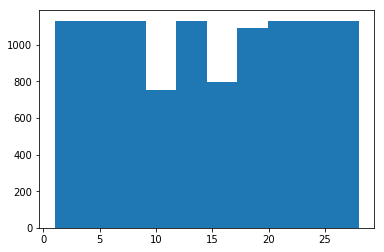

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


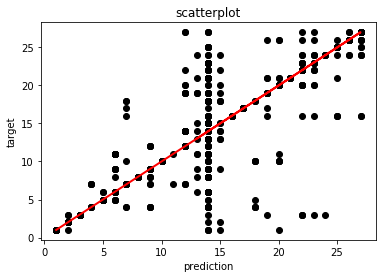

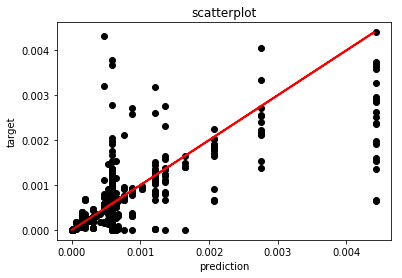

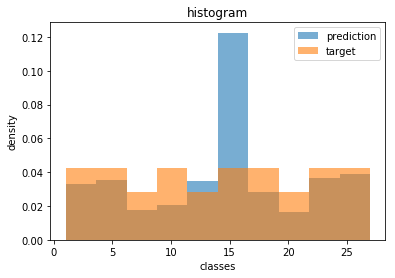

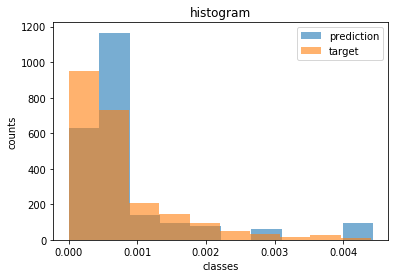

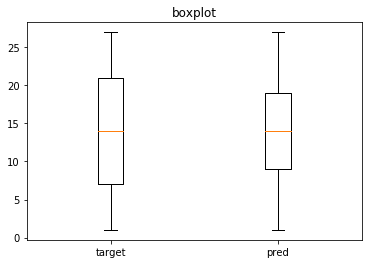

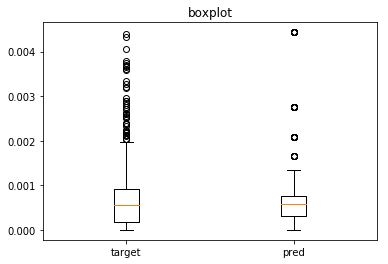

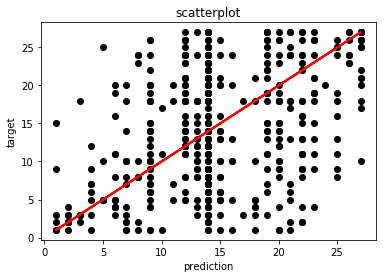

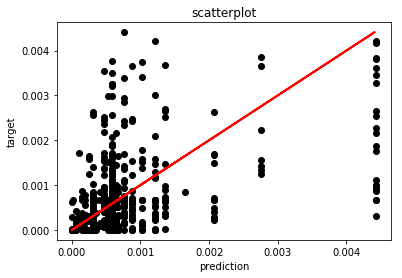

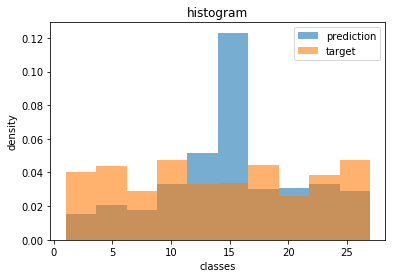

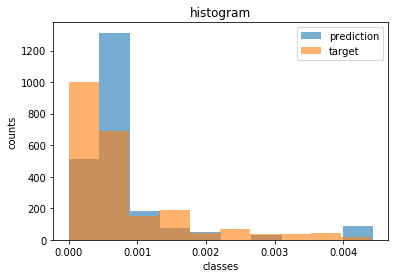

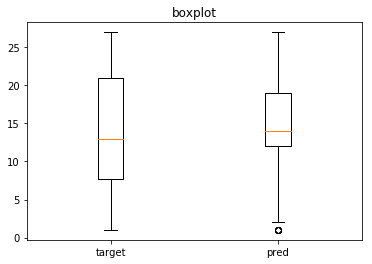

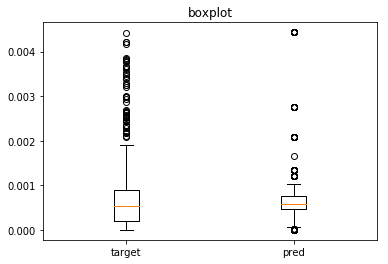

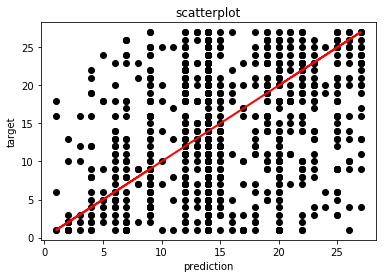

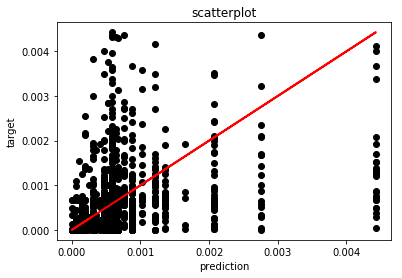

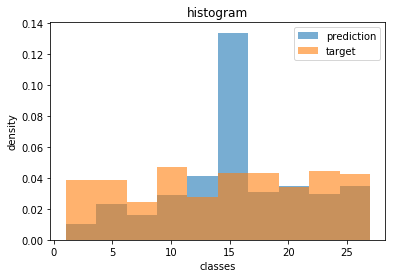

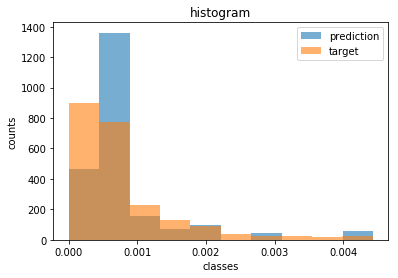

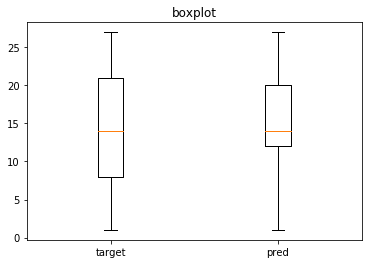

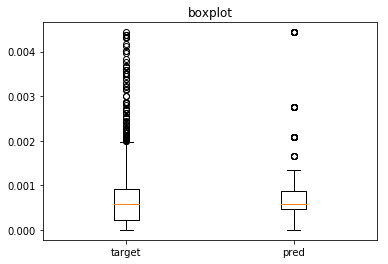

Val Loss: 3.7570, Test Accuracy: 0.107 ± 0.020, Duration: 1.800


In [14]:
bin_num_test2(dataset, n=28, epochs=100, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


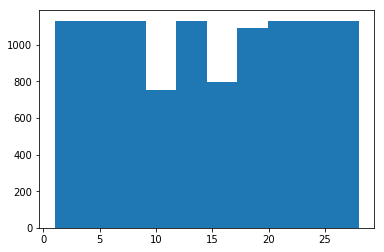

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


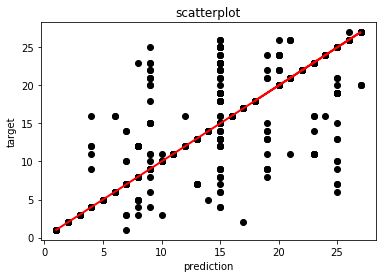

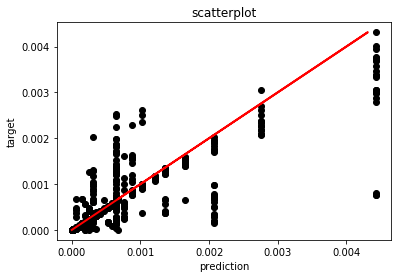

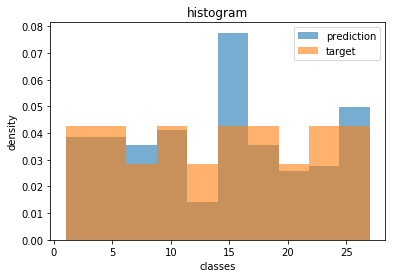

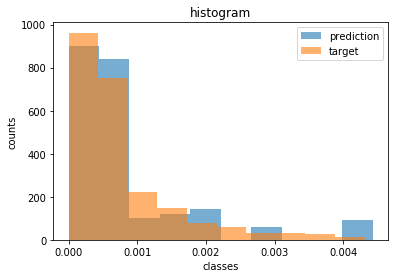

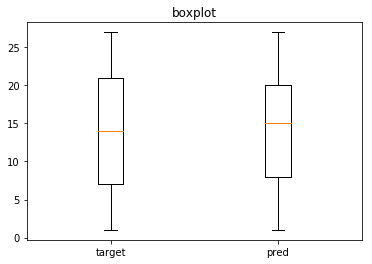

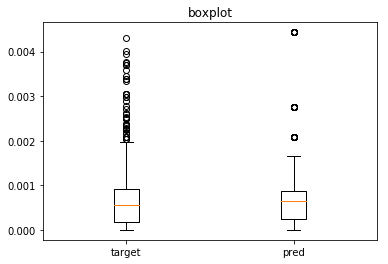

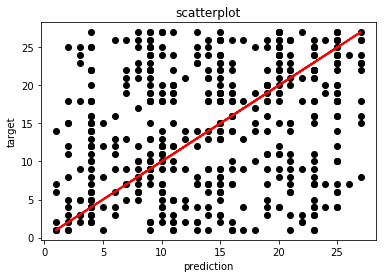

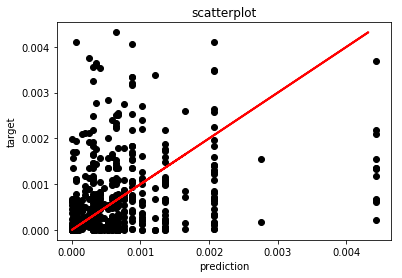

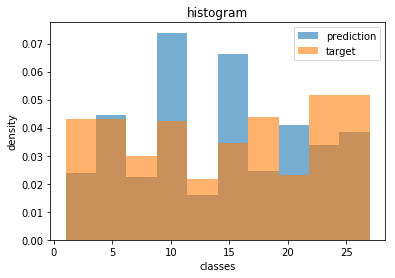

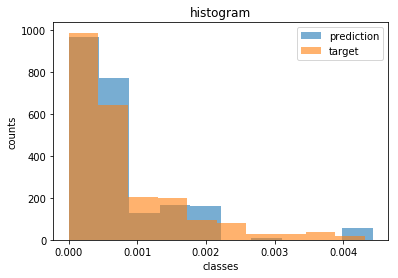

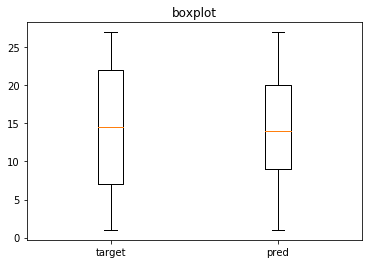

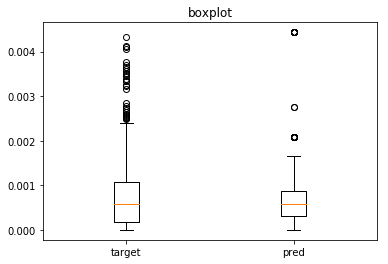

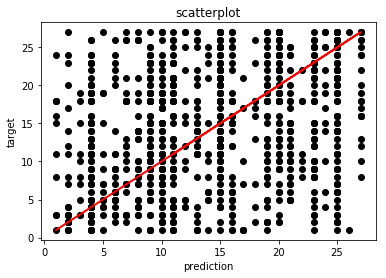

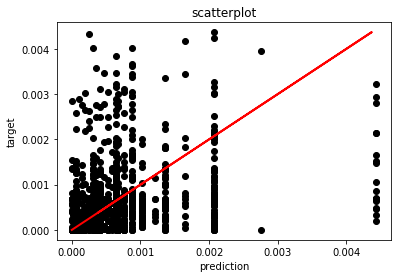

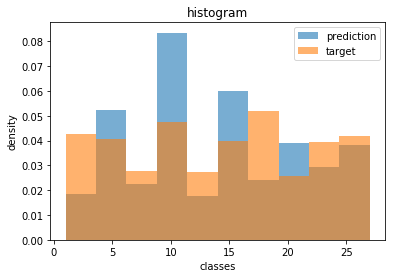

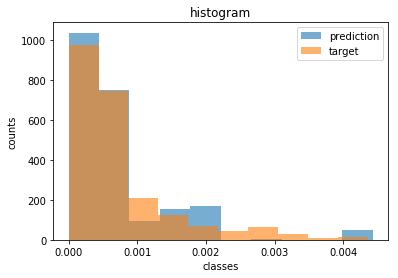

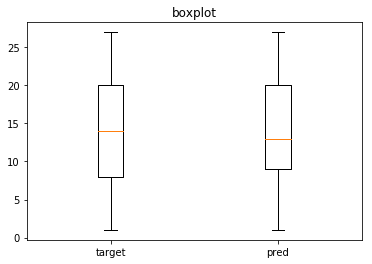

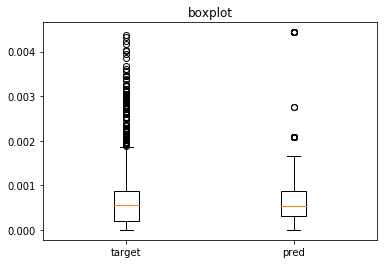

Val Loss: 4.5076, Test Accuracy: 0.094 ± 0.014, Duration: 3.585


In [15]:
bin_num_test2(dataset, n=28, epochs=200, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


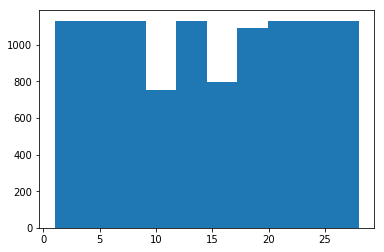

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


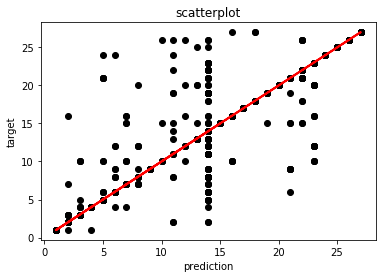

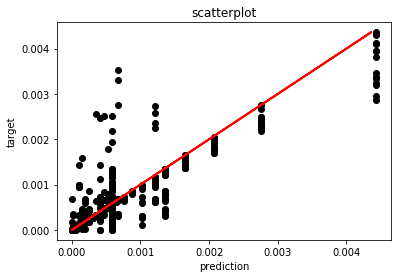

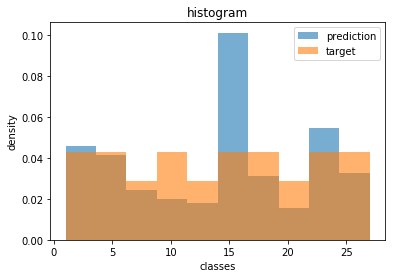

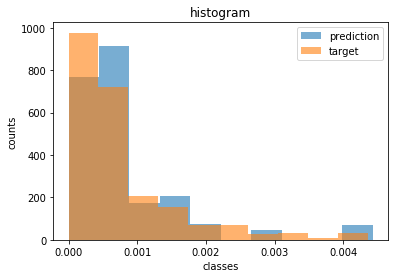

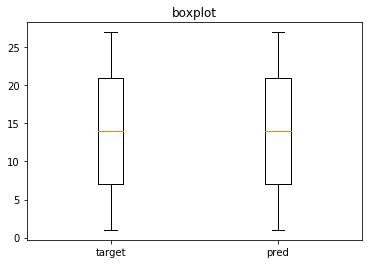

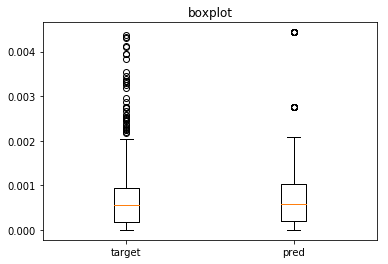

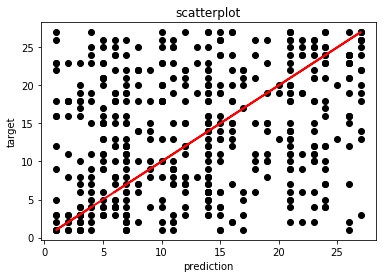

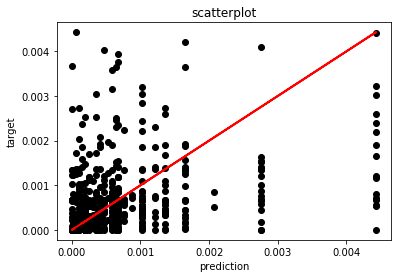

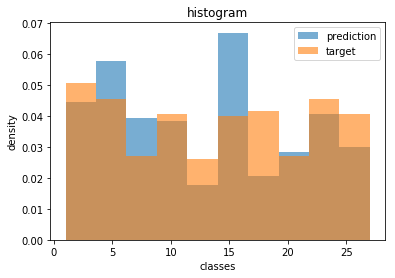

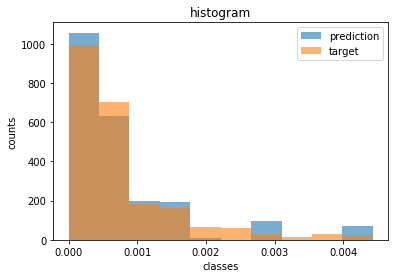

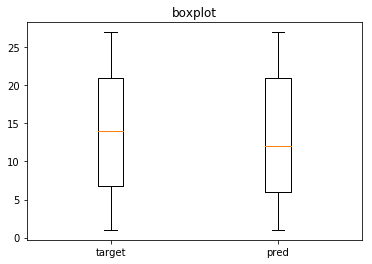

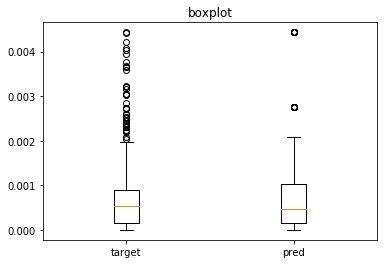

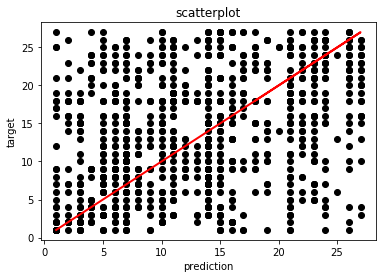

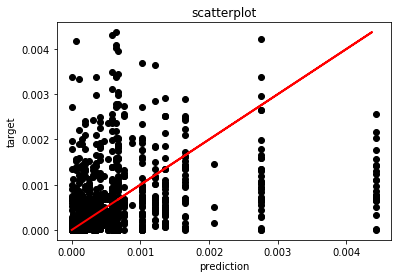

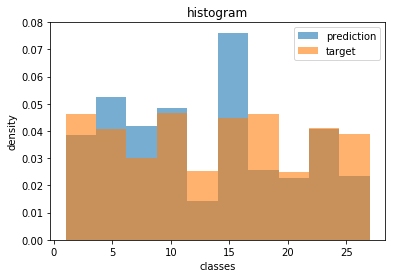

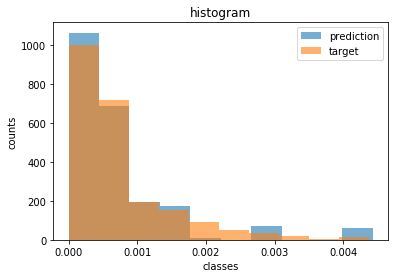

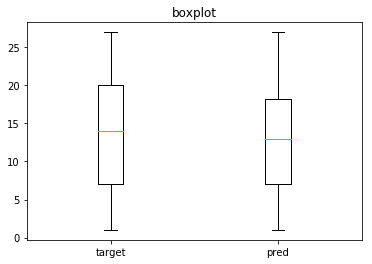

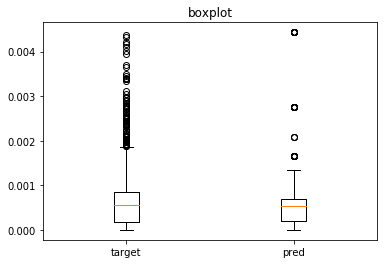

Val Loss: 4.8326, Test Accuracy: 0.089 ± 0.014, Duration: 4.439


In [16]:
bin_num_test2(dataset, n=28, epochs=250, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


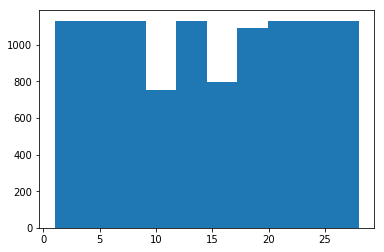

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


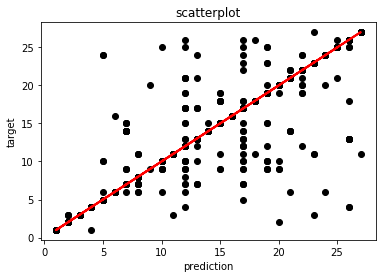

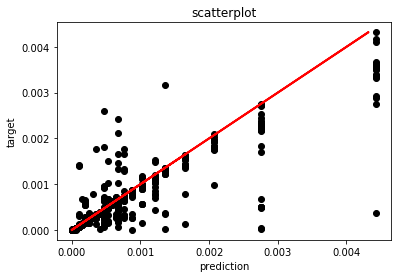

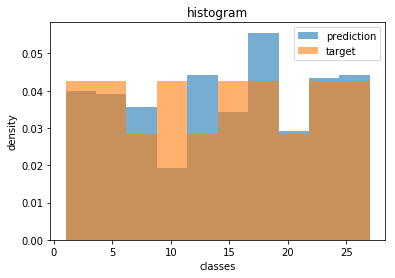

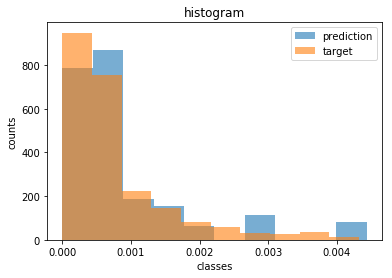

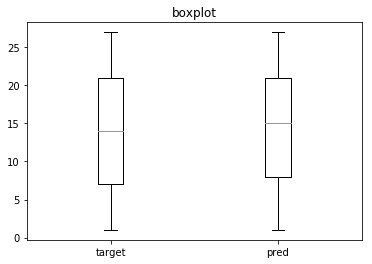

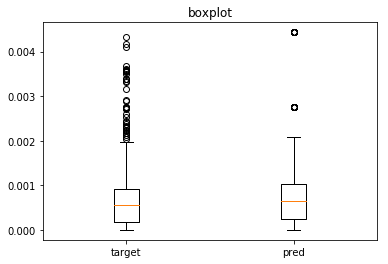

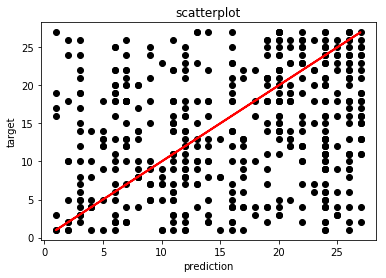

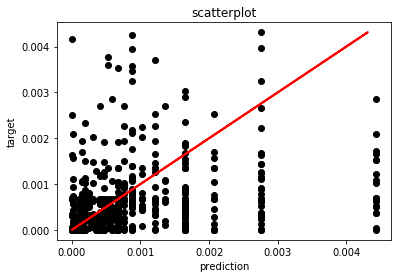

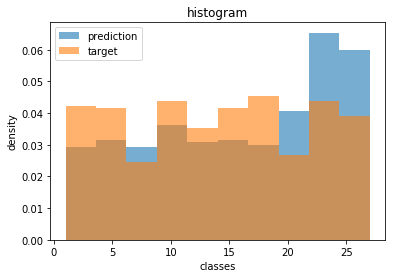

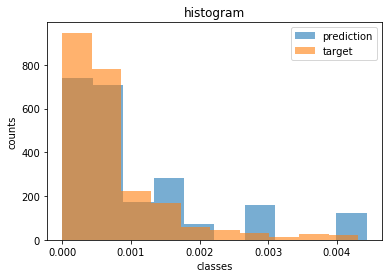

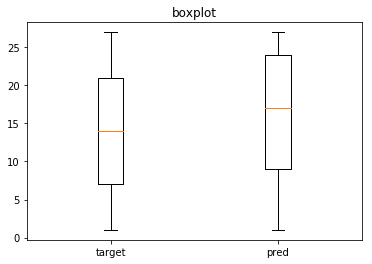

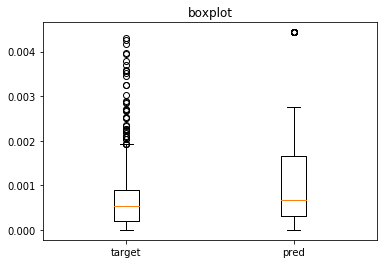

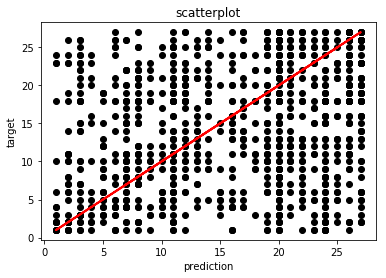

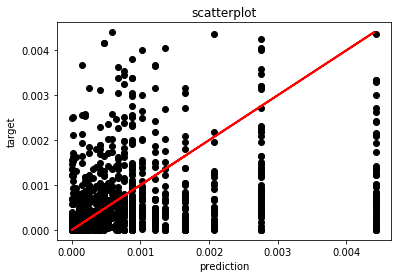

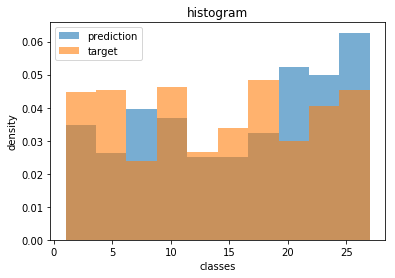

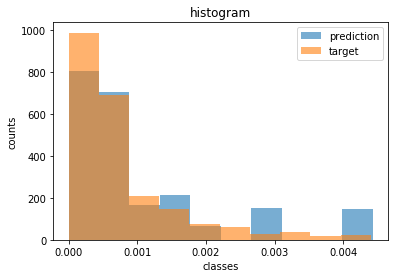

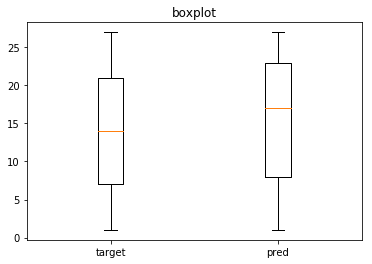

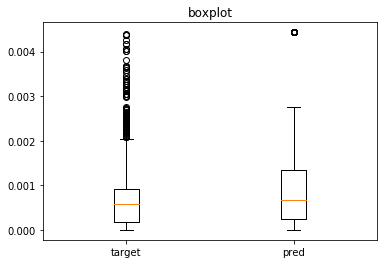

Val Loss: 5.3309, Test Accuracy: 0.083 ± 0.013, Duration: 5.290


In [17]:
bin_num_test2(dataset, n=28, epochs=300, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


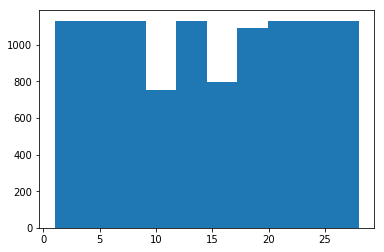

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


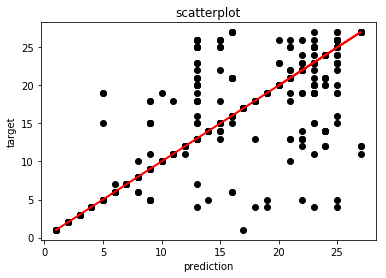

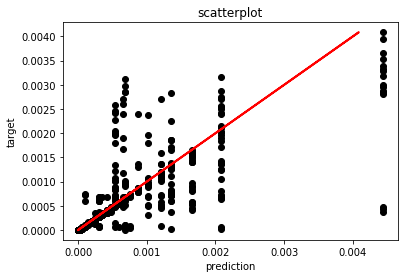

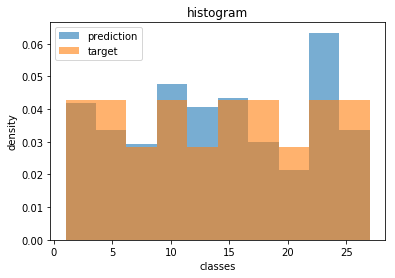

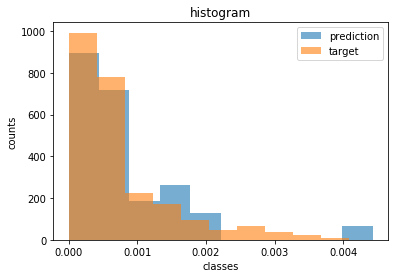

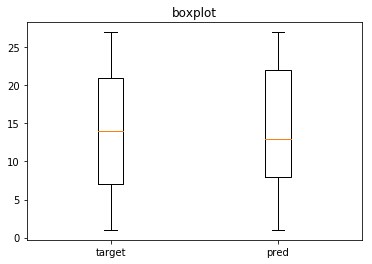

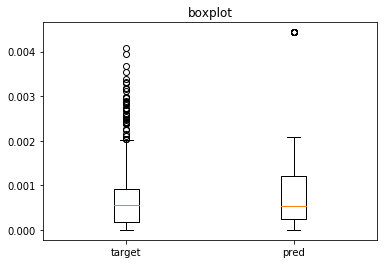

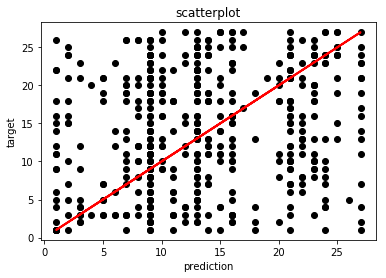

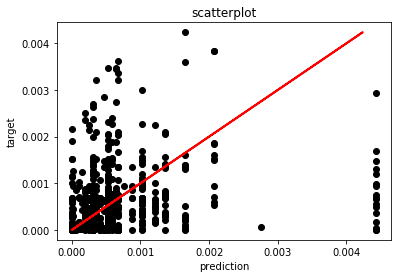

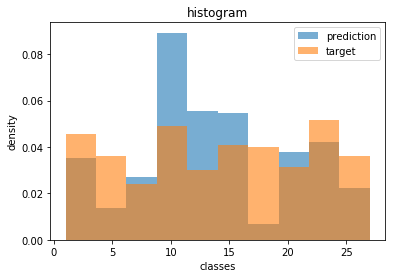

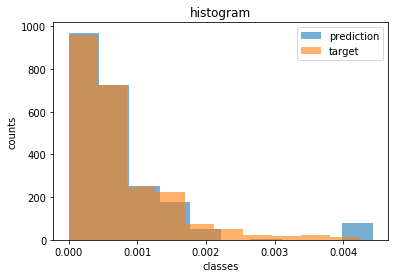

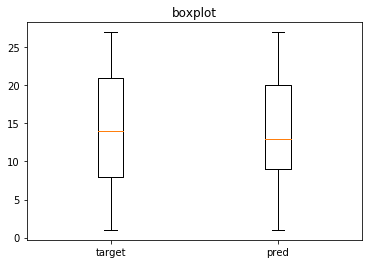

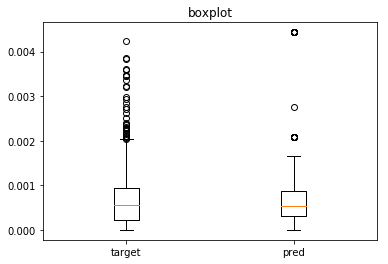

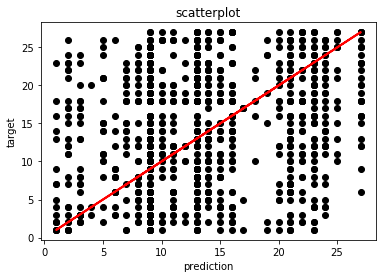

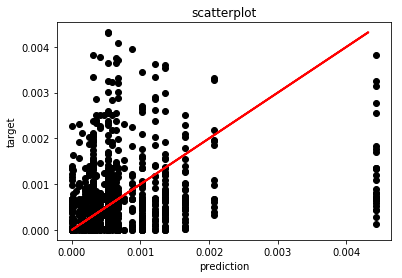

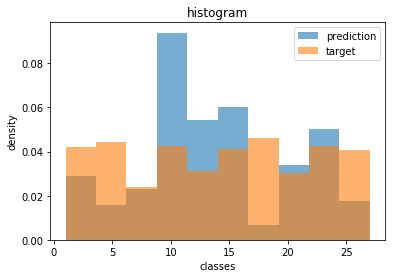

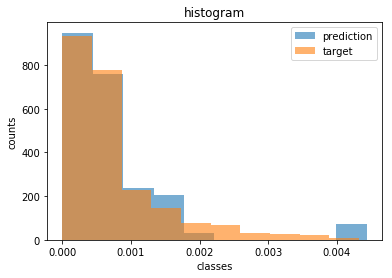

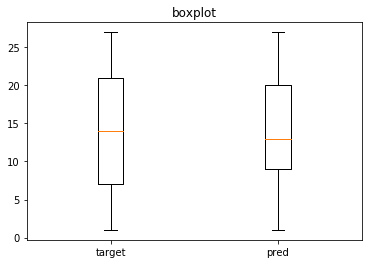

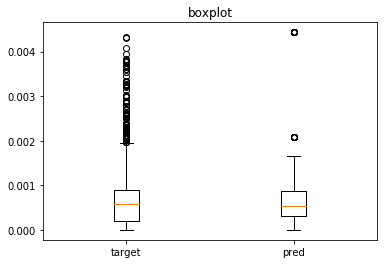

Val Loss: 5.2242, Test Accuracy: 0.088 ± 0.015, Duration: 6.054


In [18]:
bin_num_test2(dataset, n=28, epochs=350, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


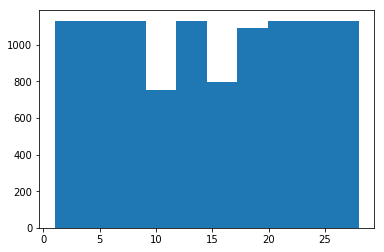

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


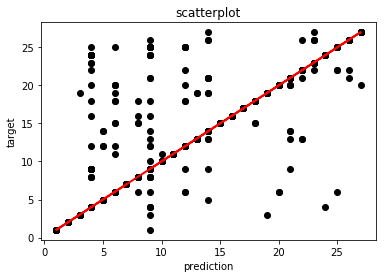

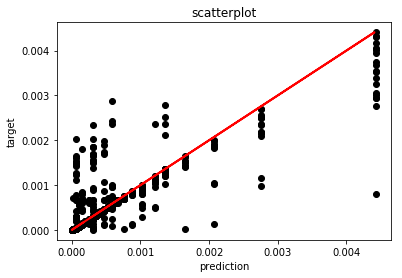

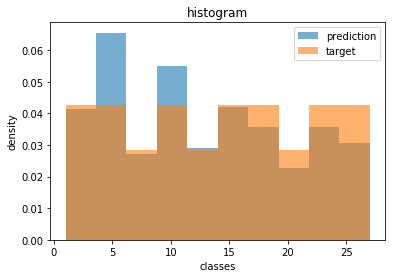

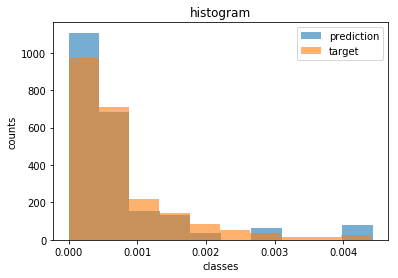

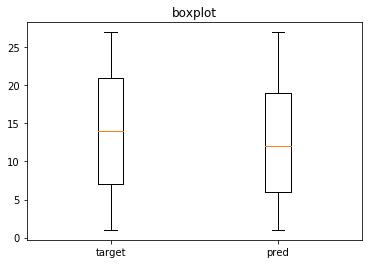

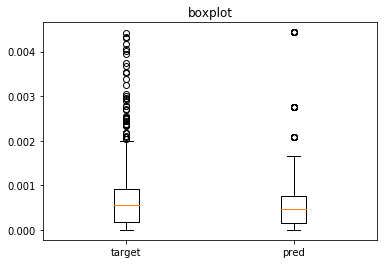

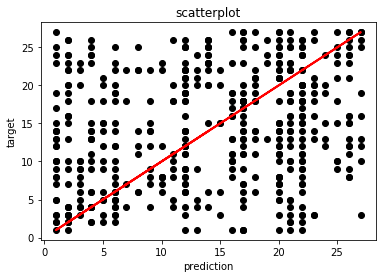

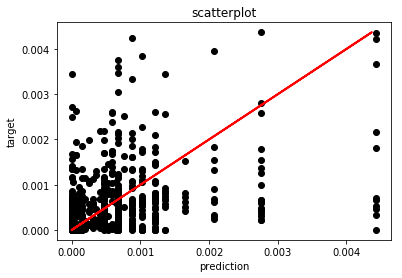

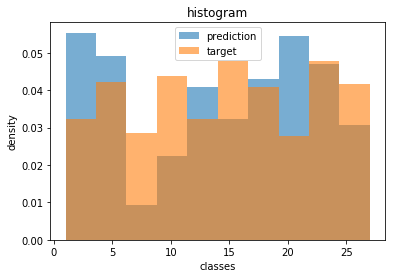

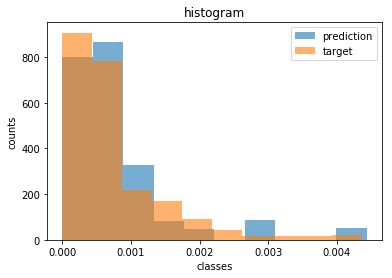

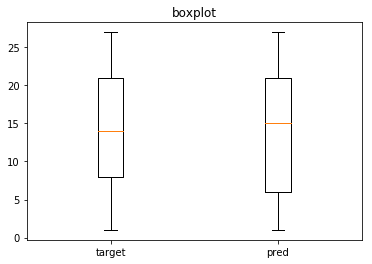

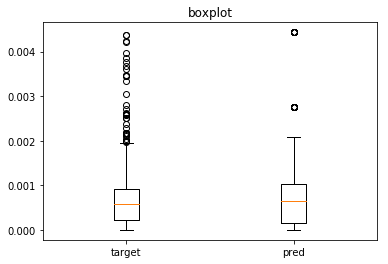

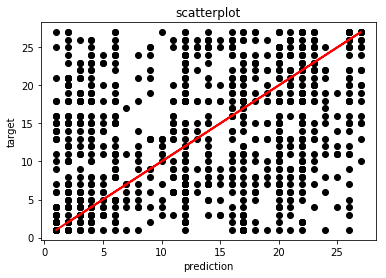

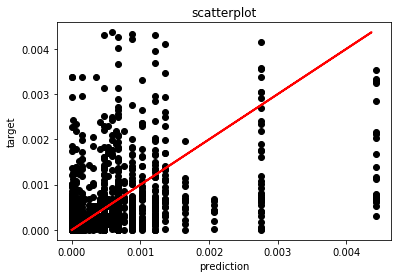

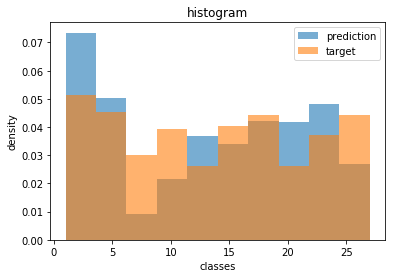

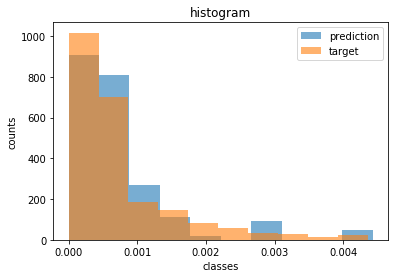

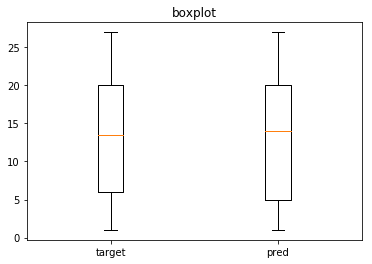

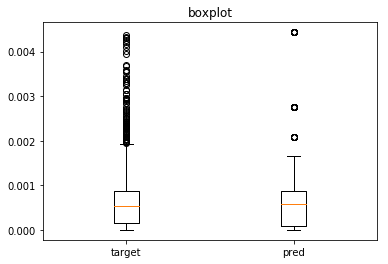

Val Loss: 5.7016, Test Accuracy: 0.083 ± 0.014, Duration: 6.846


In [19]:
bin_num_test2(dataset, n=28, epochs=400, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


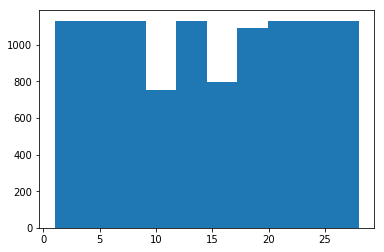

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


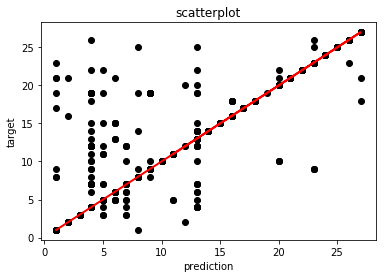

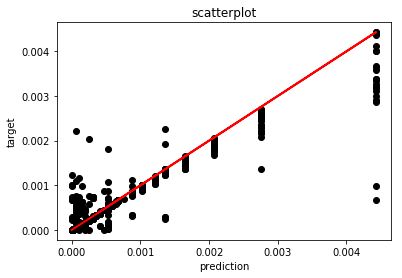

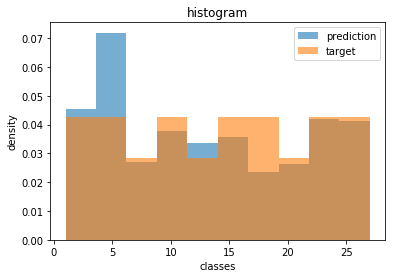

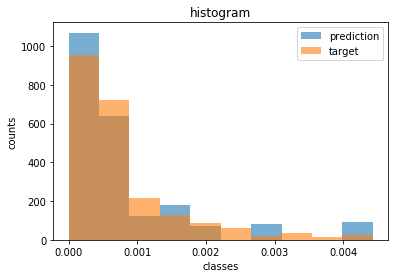

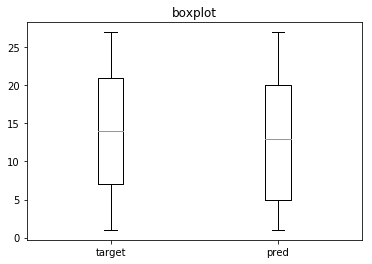

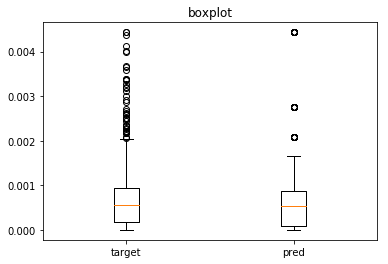

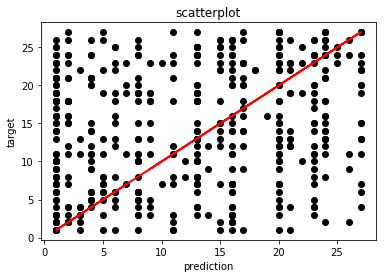

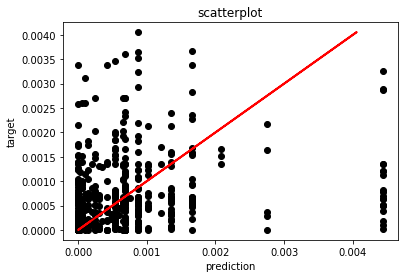

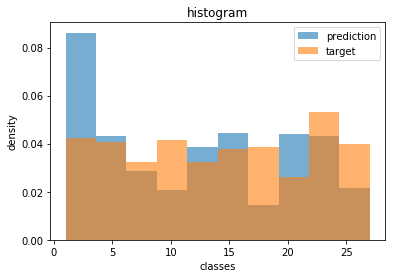

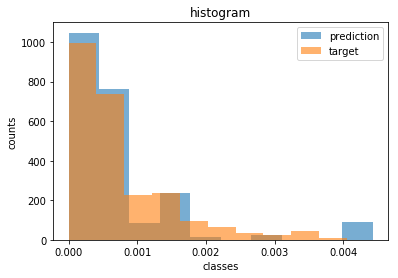

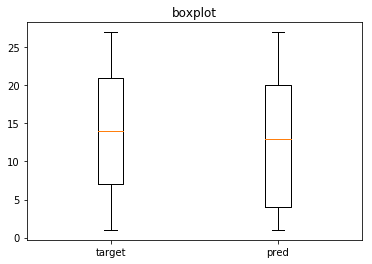

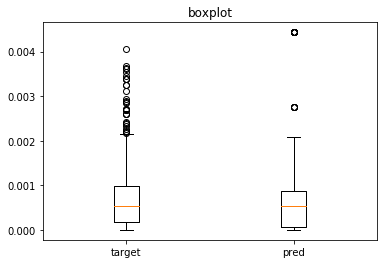

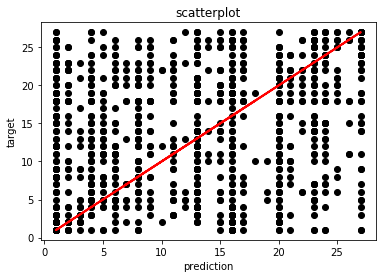

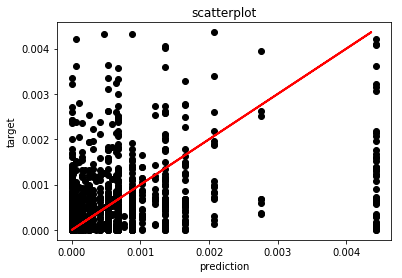

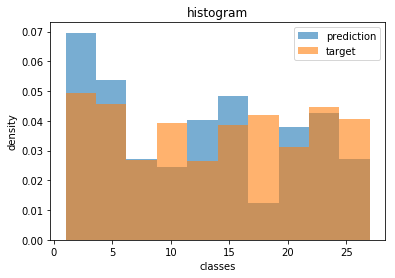

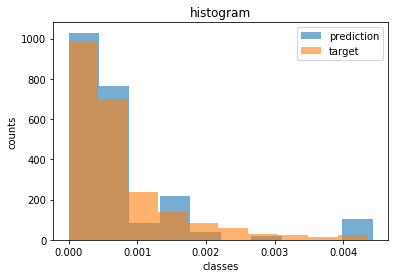

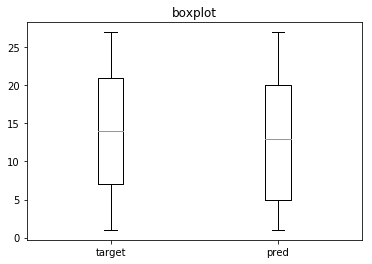

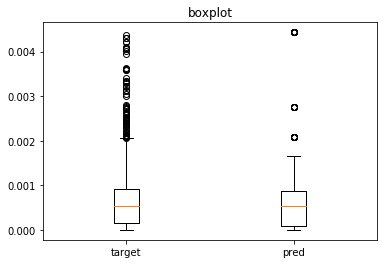

Val Loss: 5.9954, Test Accuracy: 0.082 ± 0.013, Duration: 7.720


In [20]:
bin_num_test2(dataset, n=28, epochs=450, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


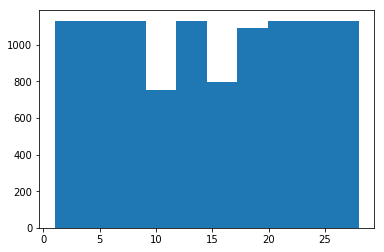

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


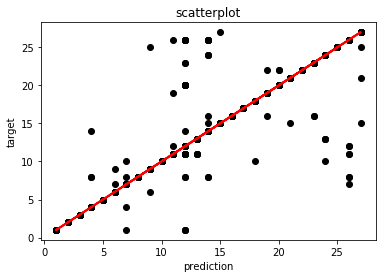

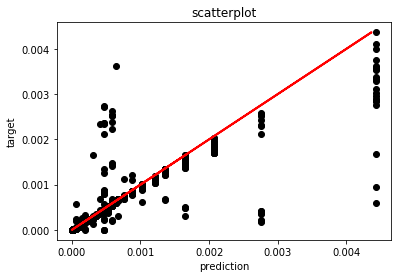

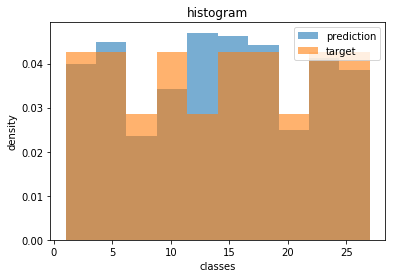

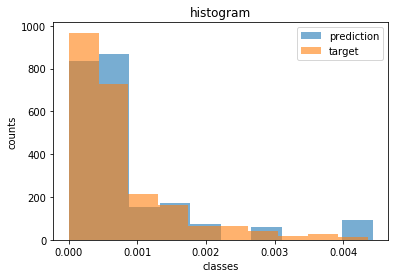

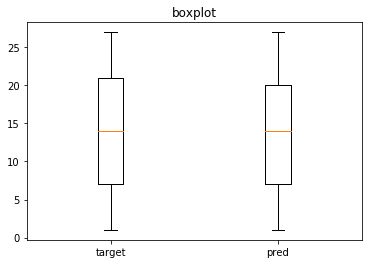

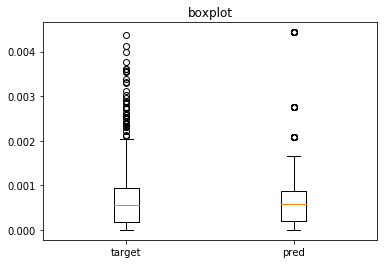

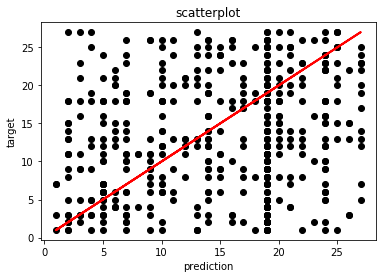

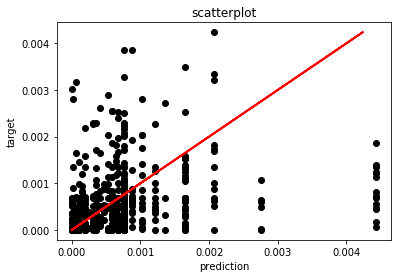

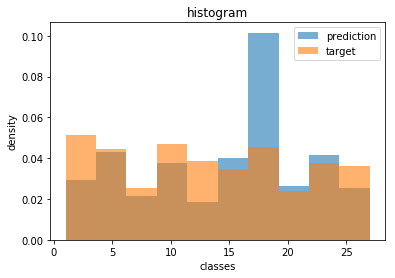

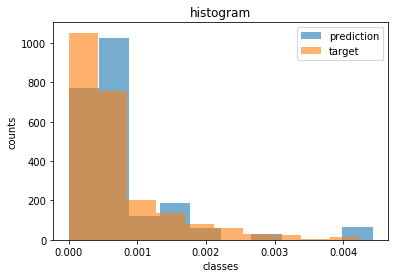

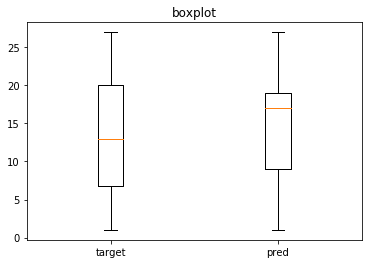

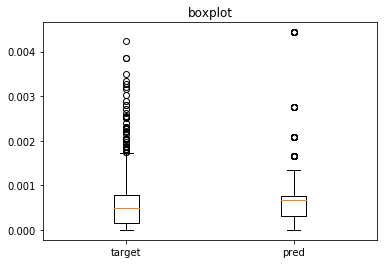

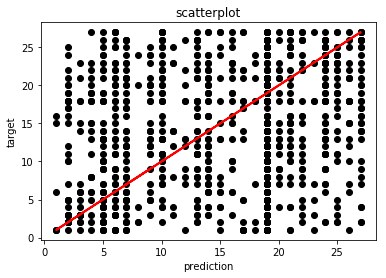

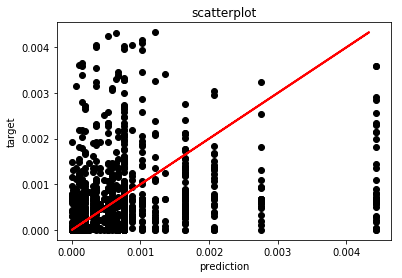

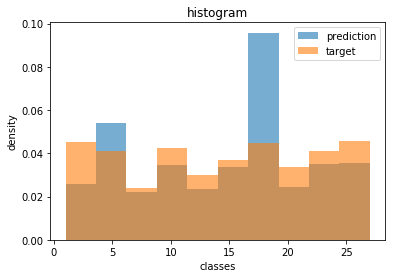

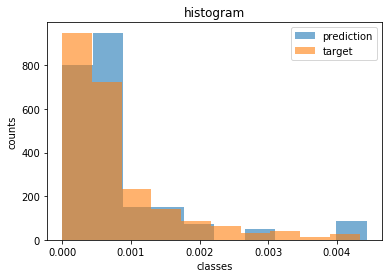

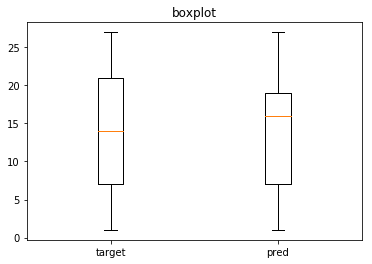

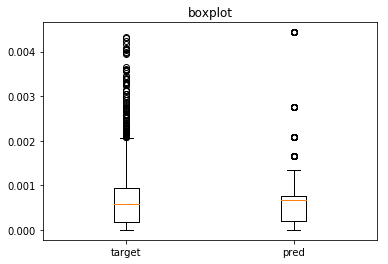

Val Loss: 6.2228, Test Accuracy: 0.084 ± 0.013, Duration: 9.396


In [21]:
bin_num_test2(dataset, n=28, epochs=550, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


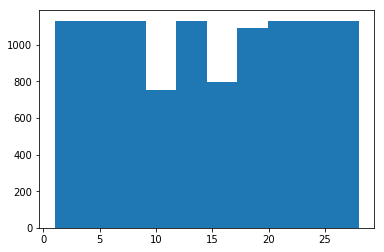

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


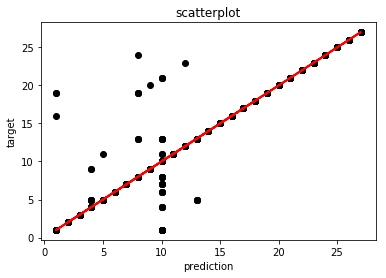

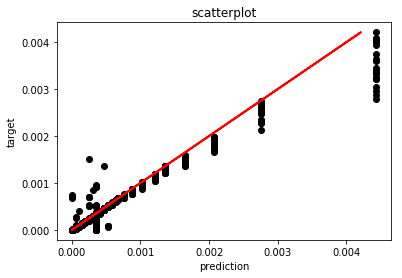

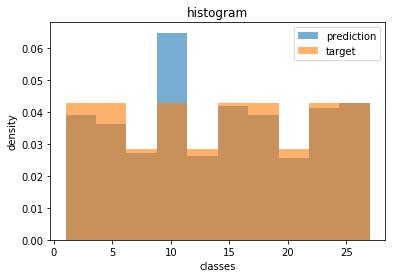

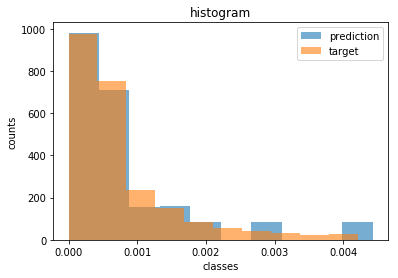

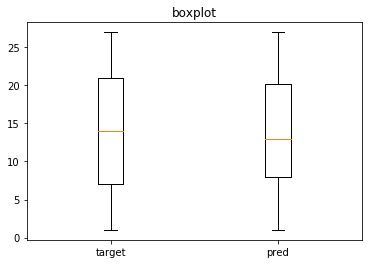

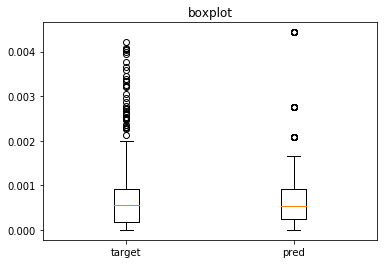

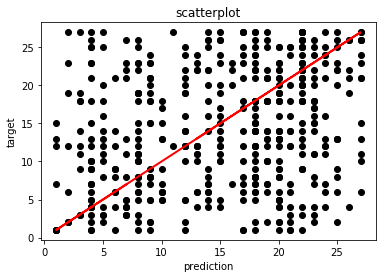

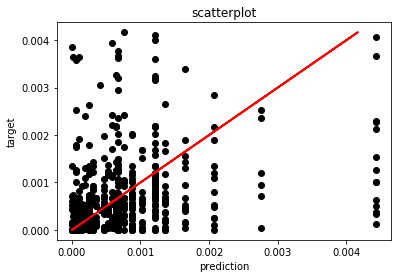

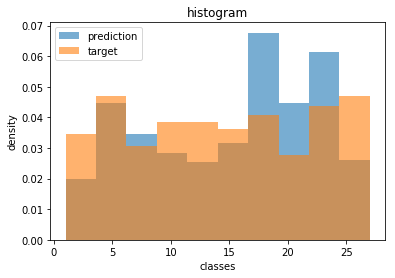

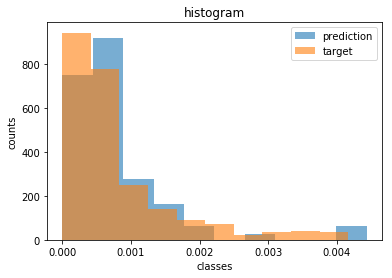

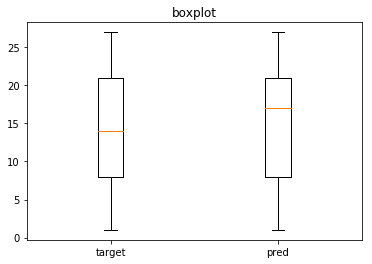

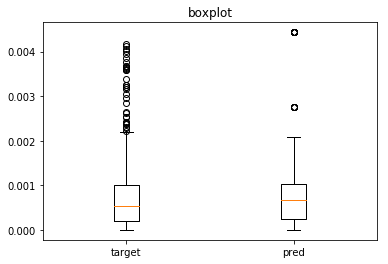

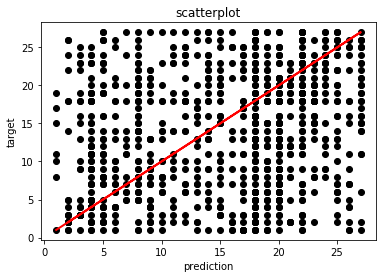

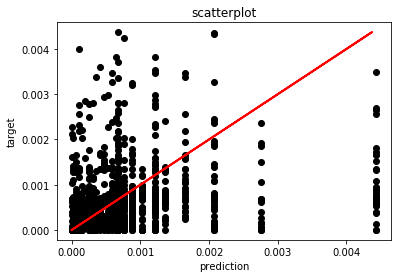

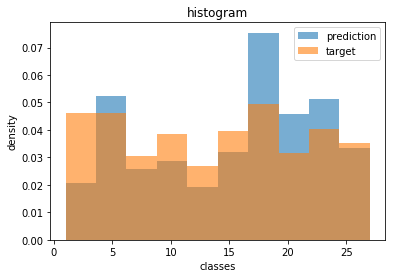

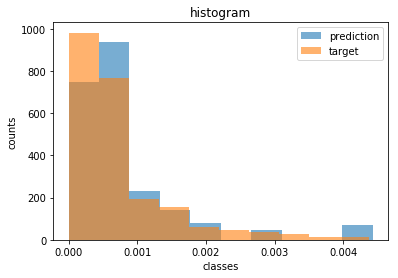

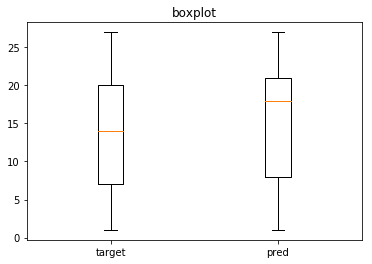

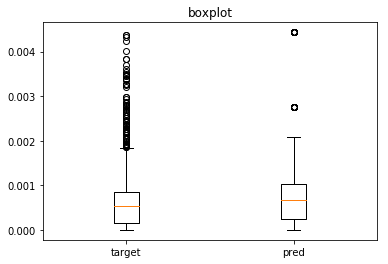

Val Loss: 6.5450, Test Accuracy: 0.081 ± 0.012, Duration: 10.338


In [22]:
bin_num_test2(dataset, n=28, epochs=600, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


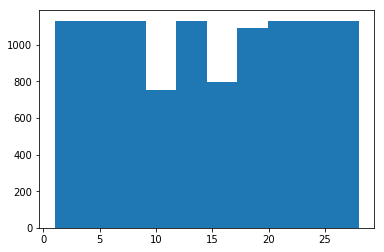

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


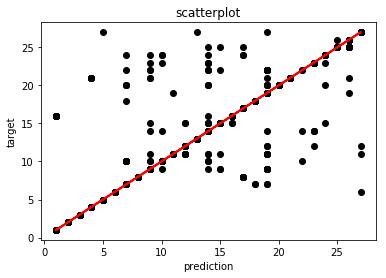

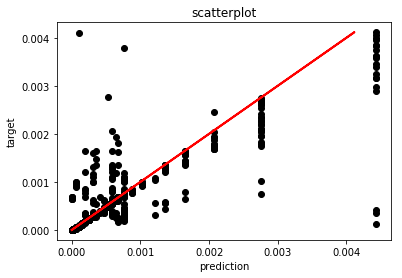

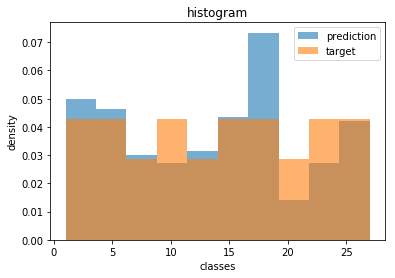

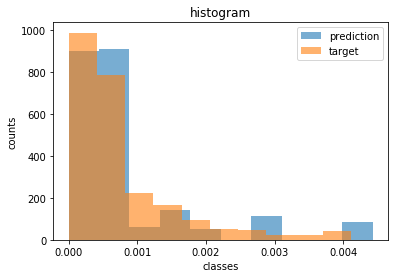

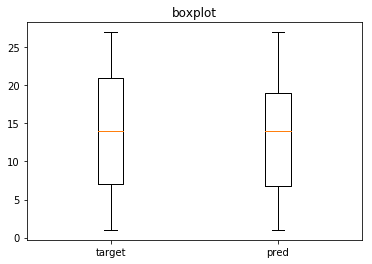

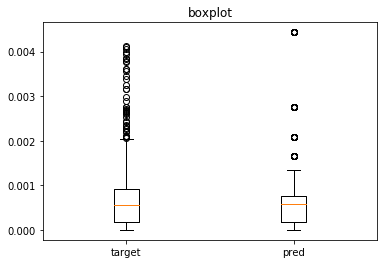

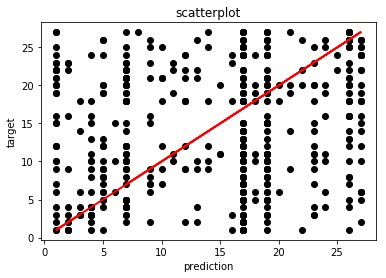

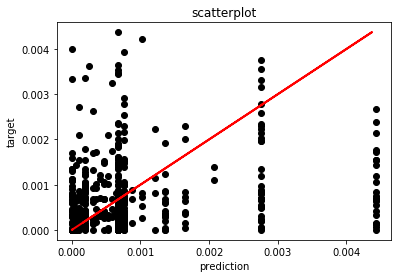

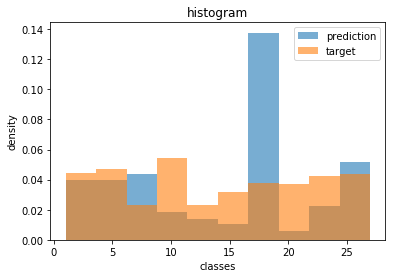

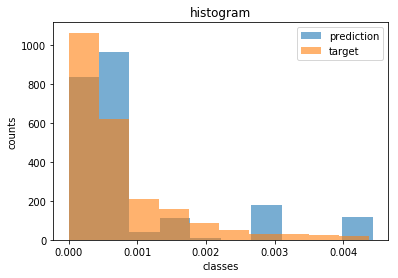

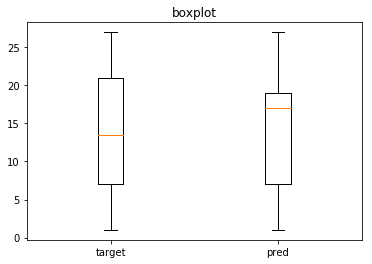

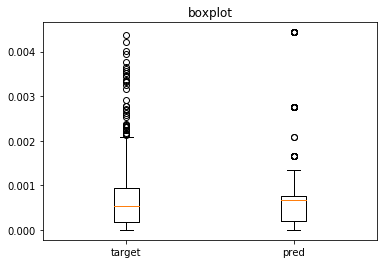

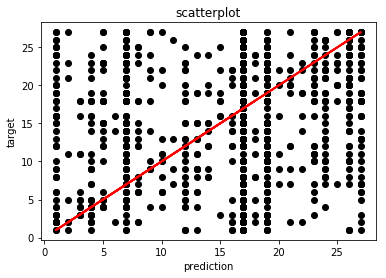

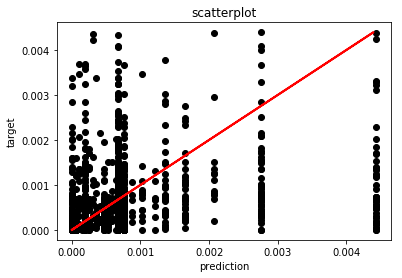

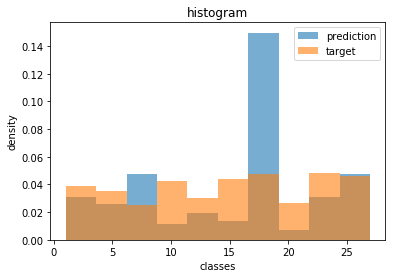

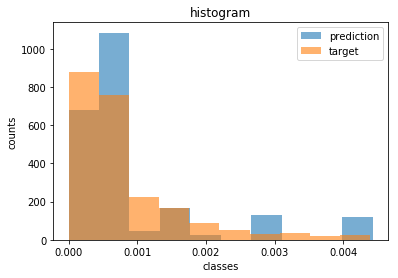

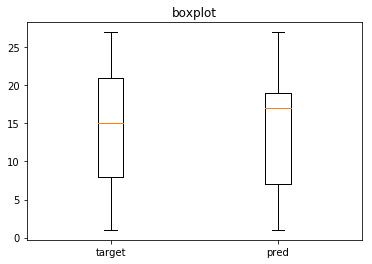

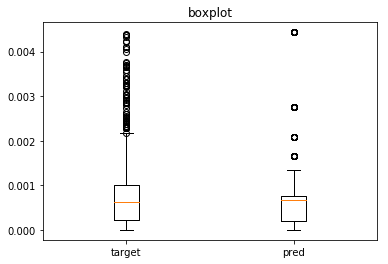

Val Loss: 6.5845, Test Accuracy: 0.082 ± 0.014, Duration: 11.119


In [23]:
bin_num_test2(dataset, n=28, epochs=650, tr_mask_length=20, val_mask_length=500, test_mask_length=1500)

### Results

In [24]:
reporting_from_csv('GN_exp1_semisuperv-28bin.csv',label='Experiment1-v2',title='Edge betweenness approximation with a graph neural network experiment')

Model  \
0   META1   
1   META1   
2   META1   
3   META1   
4   META1   
5   META1   
6   META1   
7   META1   
8   META1   
9   META1   
10  META1   
11  META1   
12  META1   
13  META1   
14  META1   
15  META1   
16  META1   
17  META1   
18  META1   
19  META1   
20  META1   
21  META1   
22  META1   
23  META1   
24  META1   
25  META1   
26  META1   
27  META1   
28  META1   
29  META1   
..    ...   
61  META1   
62  META1   
63  META1   
64  META1   
65  META1   
66  META1   
67  META1   
68  META1   
69  META1   
70  META1   
71  META1   
72  META1   
73  META1   
74  META1   
75  META1   
76  META1   
77  META1   
78  META1   
79  META1   
80  META1   
81  META1   
82  META1   
83  META1   
84  META1   
85  META1   
86  META1   
87  META1   
88  META1   
89  META1   
90  META1   

                                                                           Parameters  \
0            d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500   
1            d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500   
2            d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500   
3            d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500   
4            d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500   
5            d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500   
6         d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-1500   
7        d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-20-500-1500   
8        d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-10556   
9       d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-20-500-10556   
10      d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-4000-10556   
11     d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-20-4000-10556   
12     d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-300-4000-10556   
13    d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-300-4000-10556   
14     d4=10_d5=10_hus=10_eus=10_n1us=10_n2us=10_r=100_epochs=20_split-300-4000-10556   
15    d4=10_d5=10_hus=10_eus=10_n1us=10_n2us=10_r=100_epochs=200_split-300-4000-10556   
16   _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-300-4000-10556-   
17         _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=2_epochs=2_split-20-500-1500-   
18         _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=2_epochs=2_split-20-500-1500-   
19        _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=2_epochs=20_split-20-500-1500-   
20   _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-300-4000-10556-   
21        _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=2_epochs=20_split-20-500-1500-   
22      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-1500-   
23      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-1500-   
24      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-1500-   
25      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-1500-   
26     _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-20-500-1500-   
27     _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-10556-   
28    _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-20-500-10556-   
29         _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=2_epochs=5_split-20-500-1500-   
..                                                                                ...   
61      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=50_split-20-500-1500-   
62      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=50_split-20-500-1500-   
63      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=50_split-20-500-1500-   
64      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=50_split-20-500-15

\begin{table}[H]
\centering
\begin{tabular}{|llllccc|}
\hline
 Model &                                                                         Paramteres  &  Runs\/Epochs  &  Splits &    Loss &        Accuracy &  Time(min) \\
\hline
 META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6367 &     0.239 ± nan &      0.069 \\
 META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6338 &     0.146 ± nan &      0.071 \\
 META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6308 &     0.189 ± nan &      0.069 \\
 META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6049 &     0.273 ± nan &      0.071 \\
 META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6059 &     0.218 ± nan &      5.921 \\
 META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6045 &     0.252 ± nan &      4.065 \\
 META1 &        d19d16h10e19n16n15 & 100-20 & 20-500-1500 &  1.7550 &   0.296 ± 0.031 &      0.494 \\
 META1 &       d19d16h10e19n16n15 & 100-200 & 20-500-

'\\begin{table}[H]\n\\centering\n\\begin{tabular}{|llllccc|}\n\\hline\n Model &                                                                         Paramteres  &  Runs\\/Epochs  &  Splits &    Loss &        Accuracy &  Time(min) \\\\\n\\hline\n META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6367 &     0.239 ± nan &      0.069 \\\\\n META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6338 &     0.146 ± nan &      0.071 \\\\\n META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6308 &     0.189 ± nan &      0.069 \\\\\n META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6049 &     0.273 ± nan &      0.071 \\\\\n META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6059 &     0.218 ± nan &      5.921 \\\\\n META1 &           d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6045 &     0.252 ± nan &      4.065 \\\\\n META1 &        d19d16h10e19n16n15 & 100-20 & 20-500-1500 &  1.7550 &   0.296 ± 0.031 &      0.494 \\\\\n META1 &       d1

## Redo with different splits

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


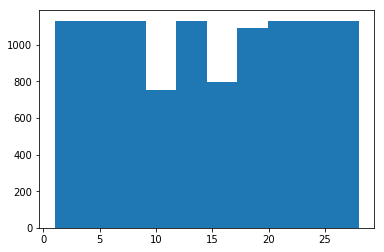

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])
Val Loss: 3.0165, Test Accuracy: 0.112 ± 0.047, Test F1-macro: 0.088 ± 0.052, Duration: 0.081


In [125]:
bin_num_test2(dataset, n=28, epochs=2,tr_mask_length=20, val_mask_length=500, test_mask_length=10556, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


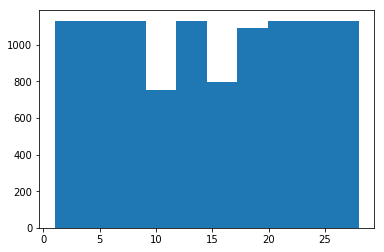

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


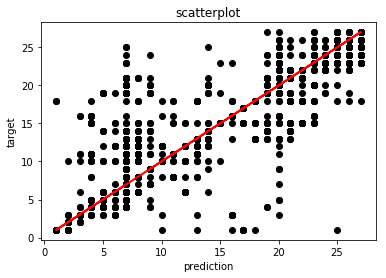

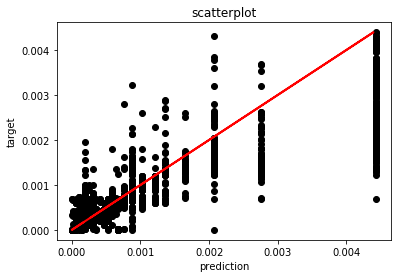

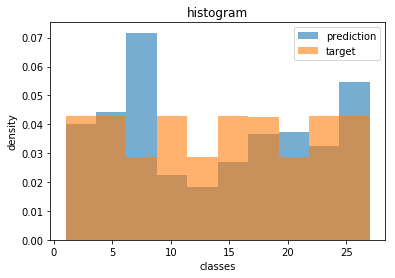

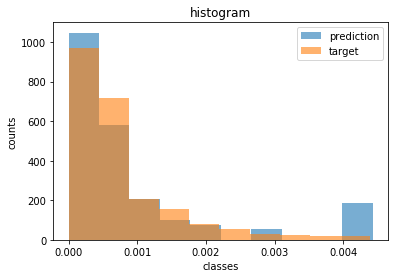

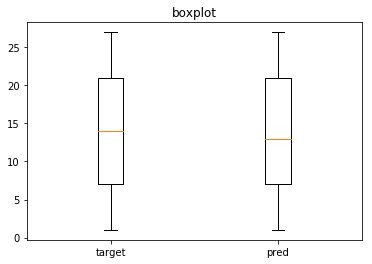

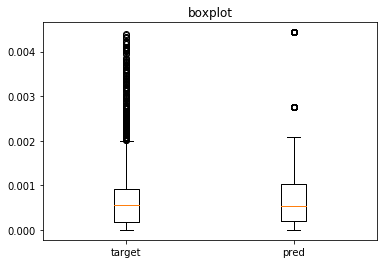

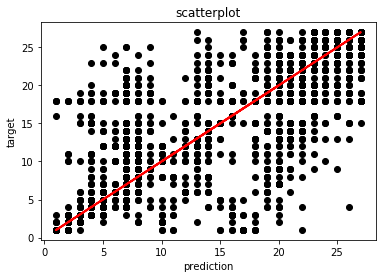

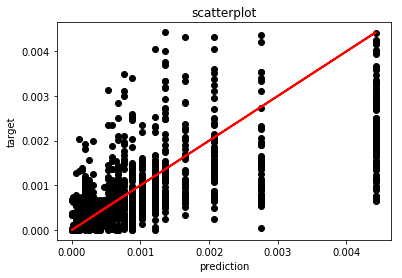

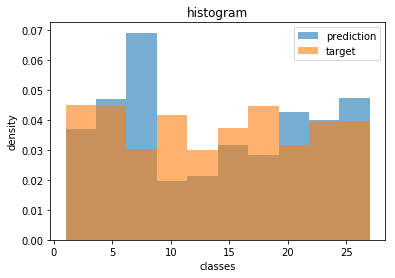

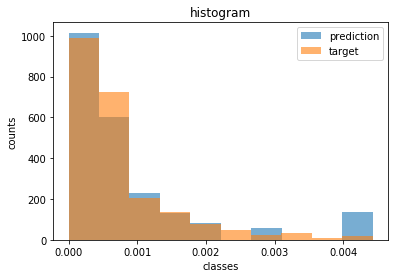

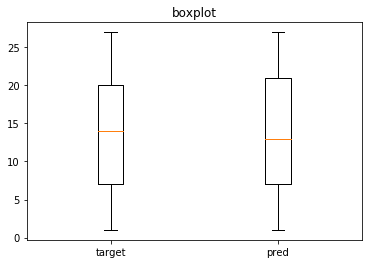

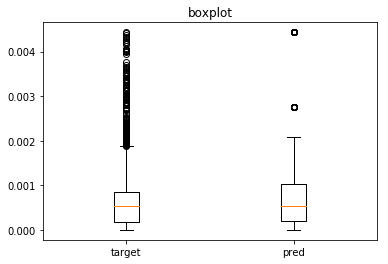

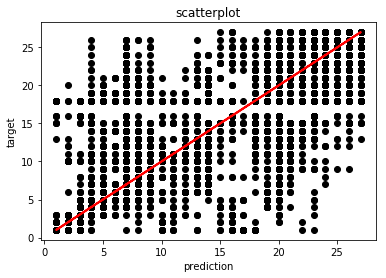

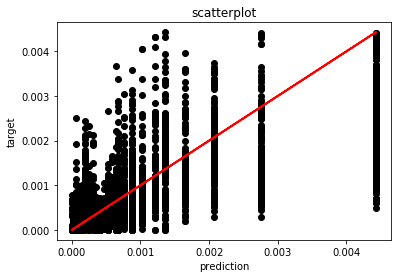

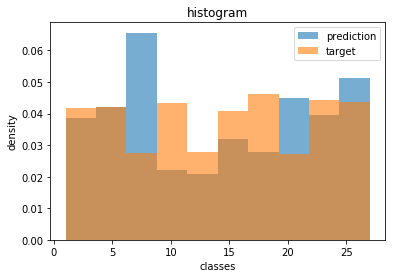

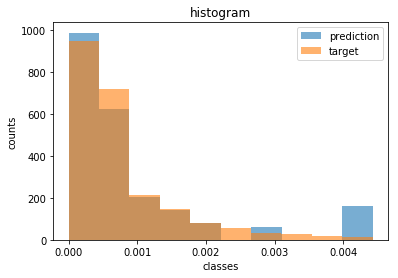

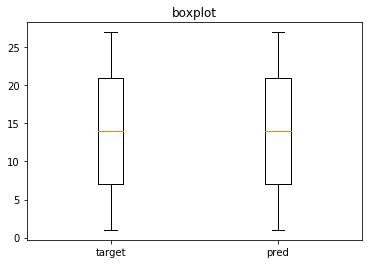

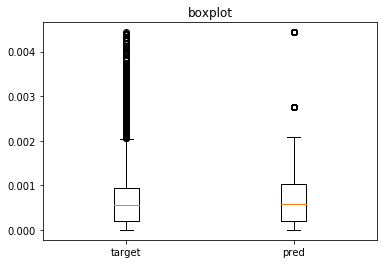

Val Loss: 2.3561, Test Accuracy: 0.280 ± 0.061, Test F1-macro: 0.251 ± 0.060, Duration: 0.484


In [118]:
bin_num_test2(dataset, n=28, epochs=20,tr_mask_length=100, val_mask_length=2000, test_mask_length=10556, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


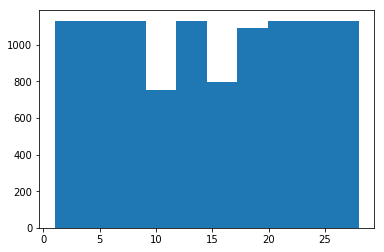

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


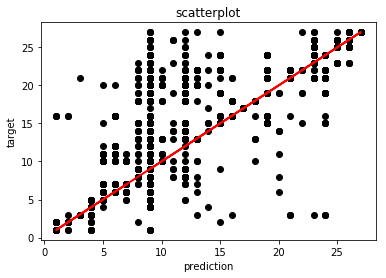

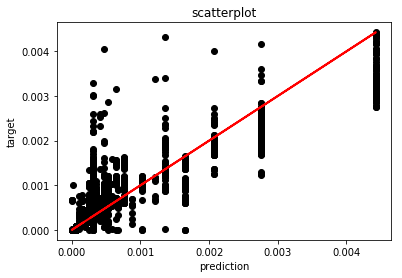

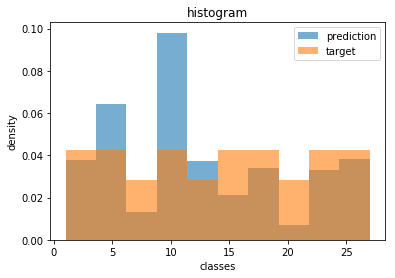

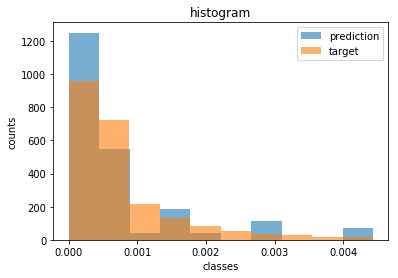

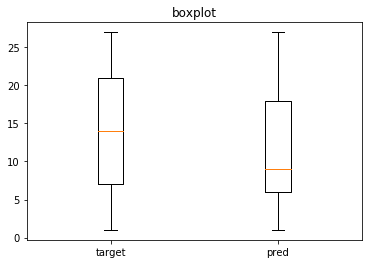

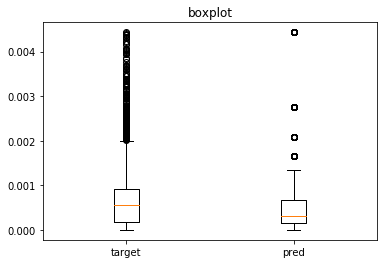

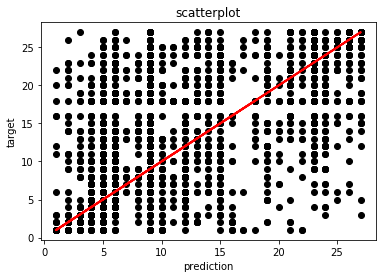

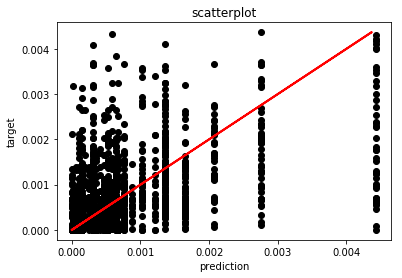

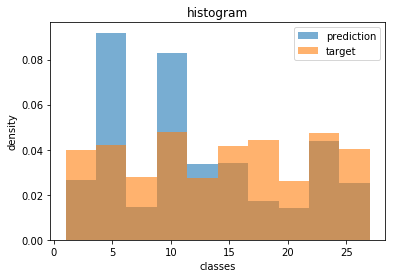

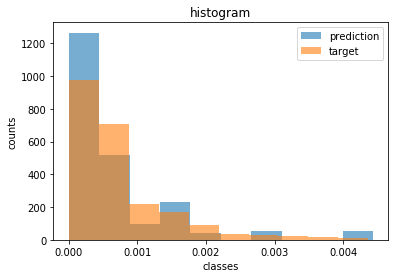

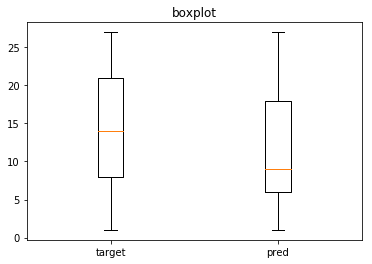

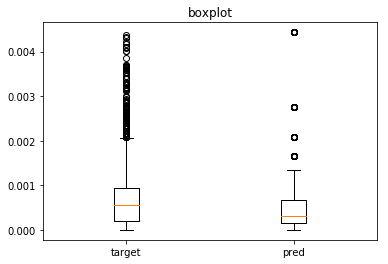

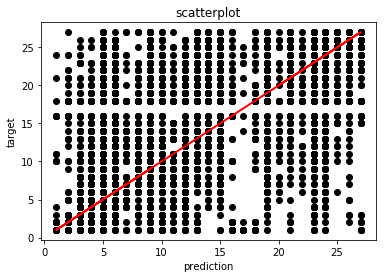

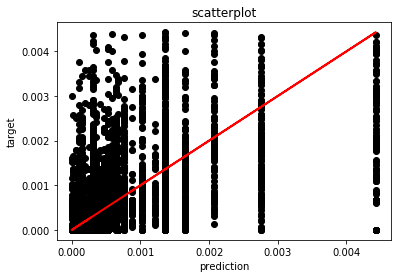

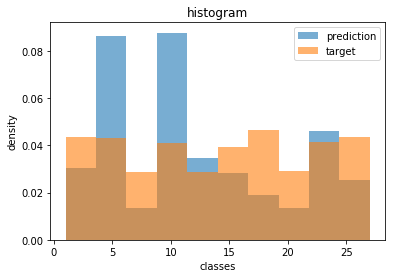

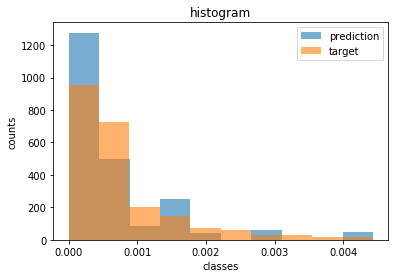

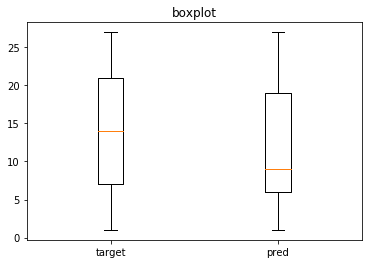

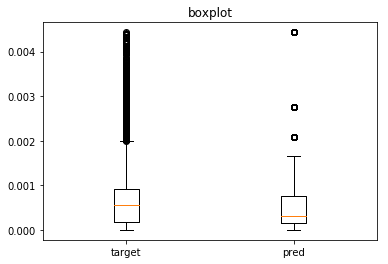

Val Loss: 3.8995, Test Accuracy: 0.139 ± 0.018, Test F1-macro: 0.128 ± 0.020, Duration: 5.108


In [119]:
bin_num_test2(dataset, n=28, epochs=250,tr_mask_length=100, val_mask_length=2000, test_mask_length=10556, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


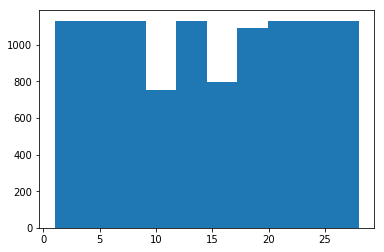

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


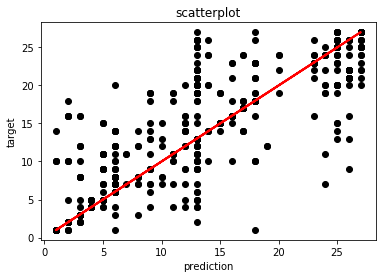

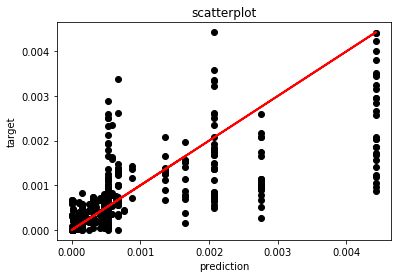

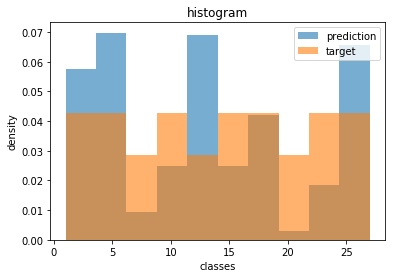

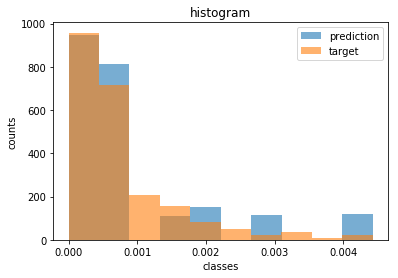

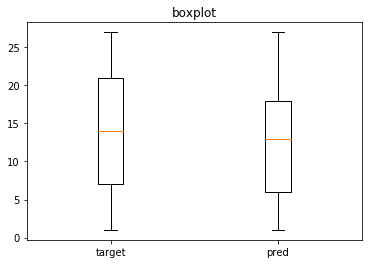

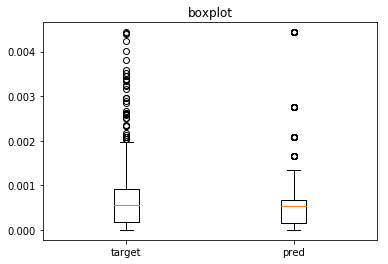

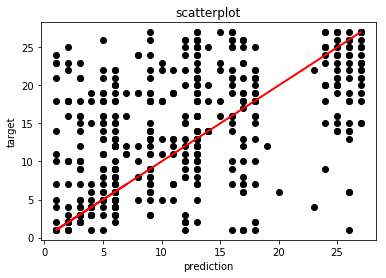

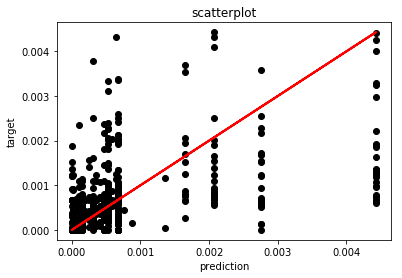

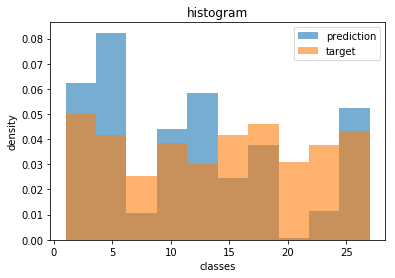

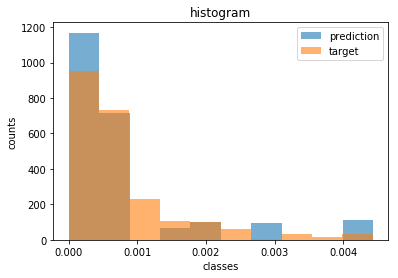

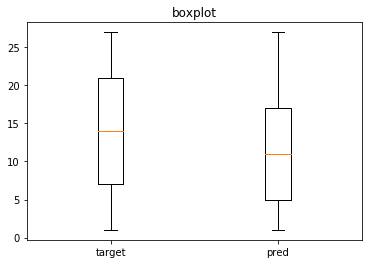

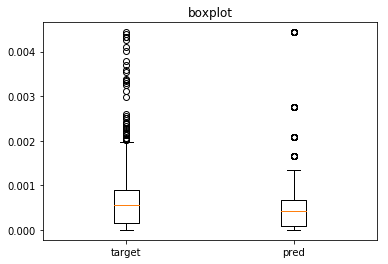

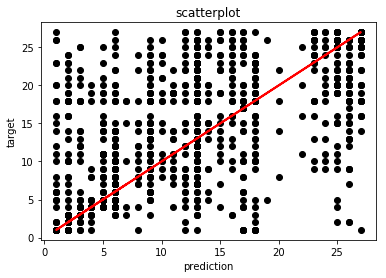

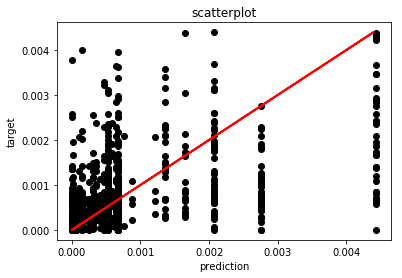

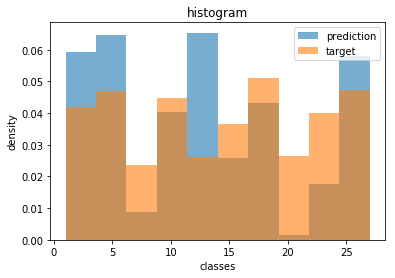

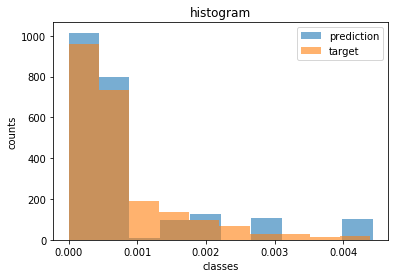

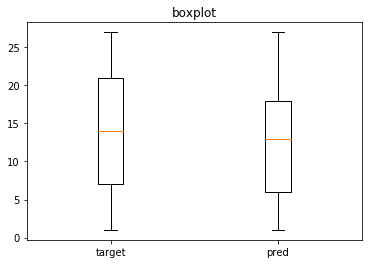

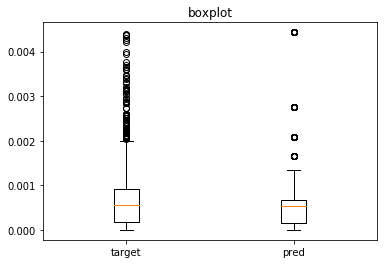

Val Loss: 3.0269, Test Accuracy: 0.142 ± 0.027, Test F1-macro: 0.127 ± 0.029, Duration: 0.502


In [120]:
bin_num_test2(dataset, n=28, epochs=20,tr_mask_length=20, val_mask_length=500, test_mask_length=1500, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


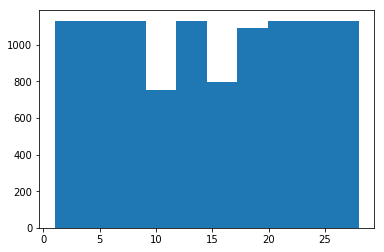

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


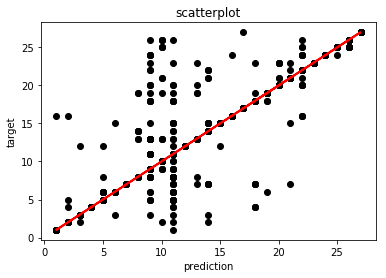

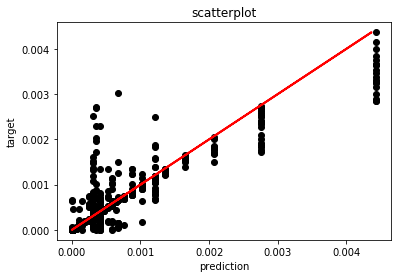

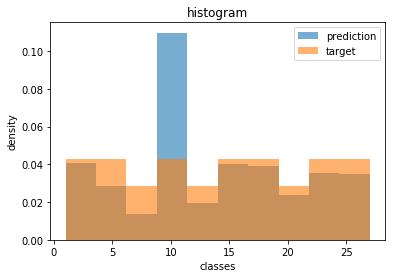

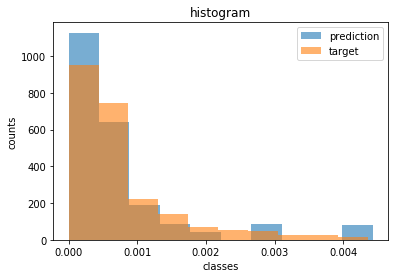

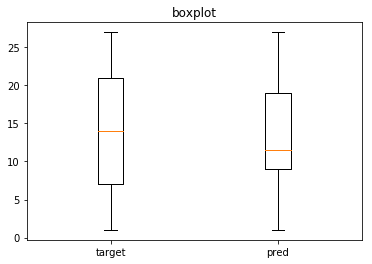

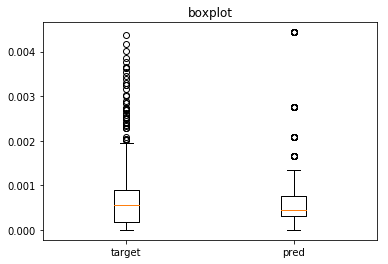

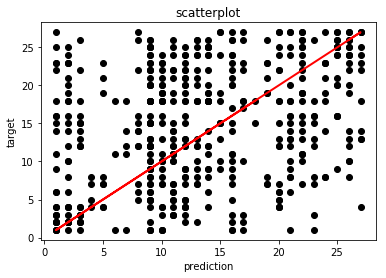

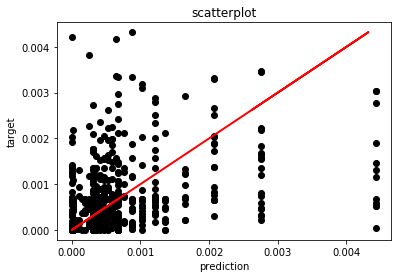

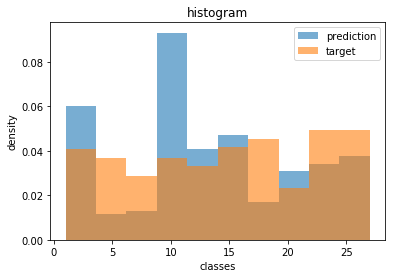

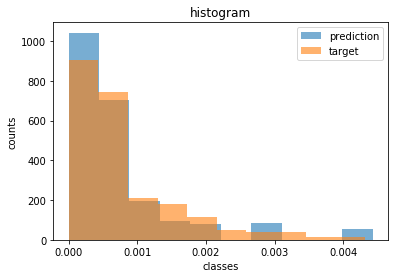

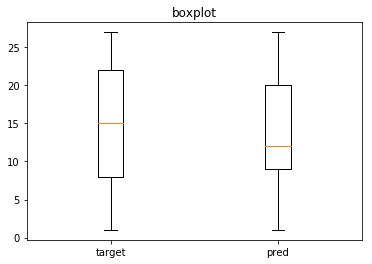

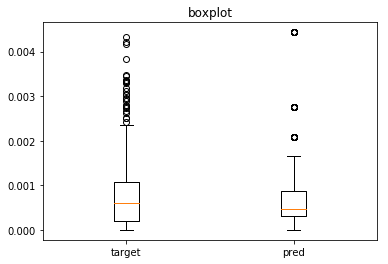

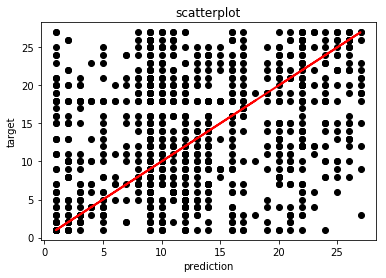

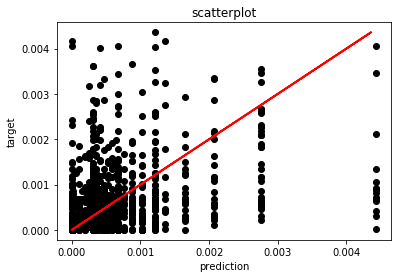

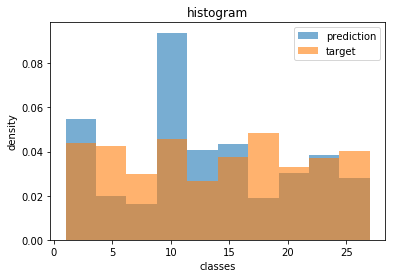

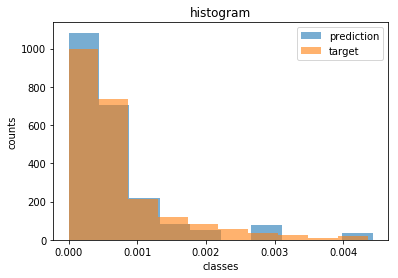

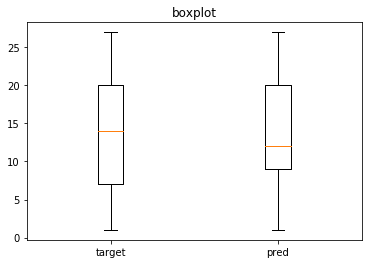

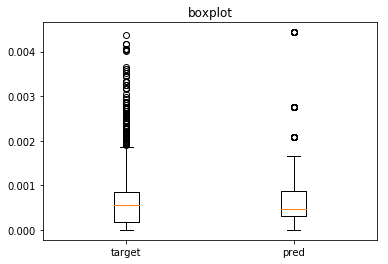

Val Loss: 4.9482, Test Accuracy: 0.093 ± 0.013, Test F1-macro: 0.087 ± 0.017, Duration: 4.801


In [121]:
bin_num_test2(dataset, n=28, epochs=250,tr_mask_length=20, val_mask_length=500, test_mask_length=1500, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


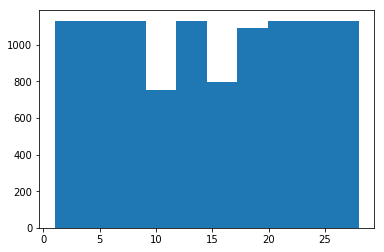

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


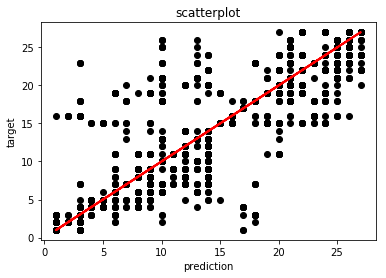

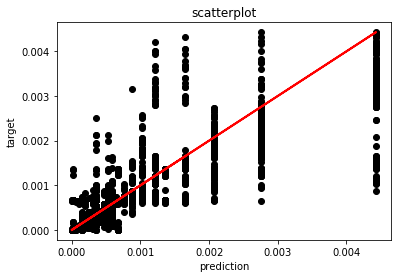

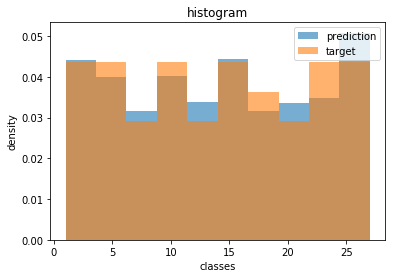

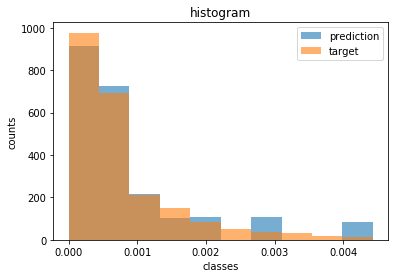

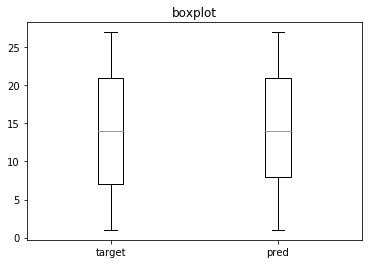

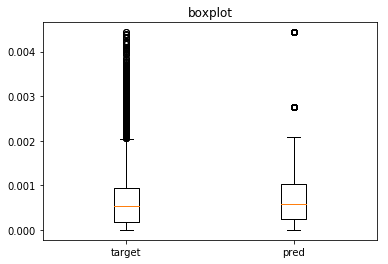

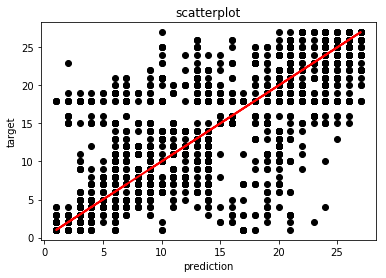

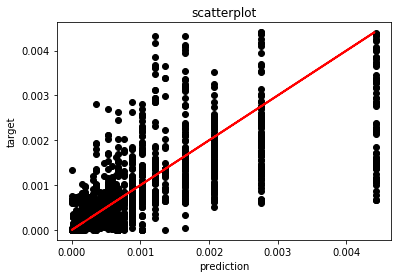

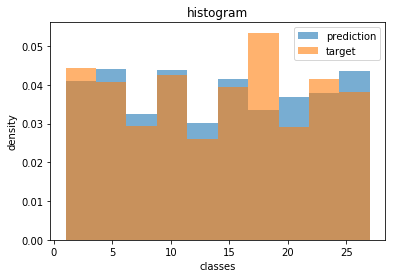

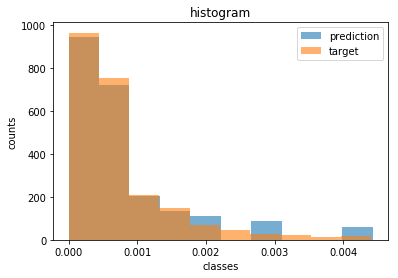

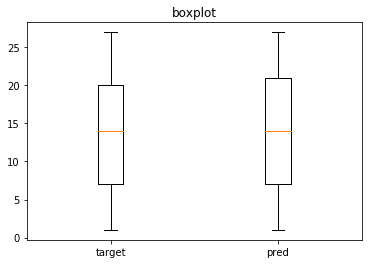

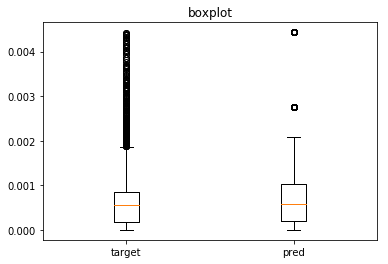

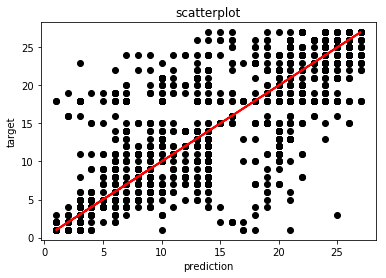

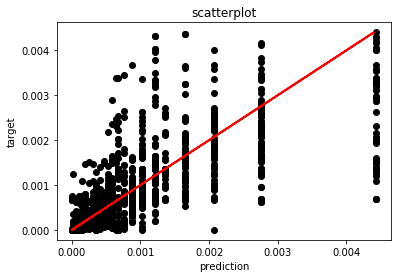

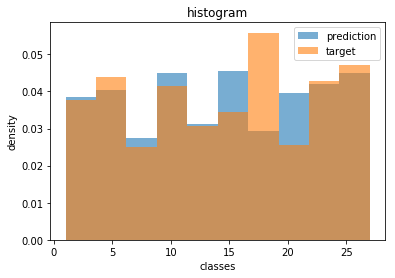

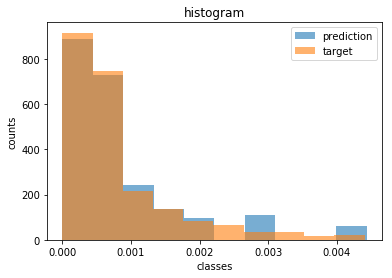

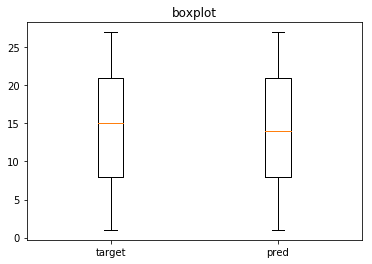

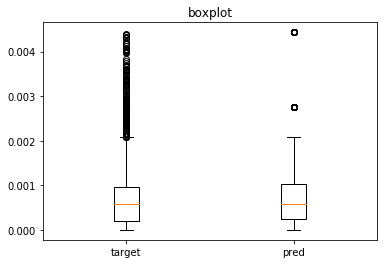

Val Loss: 2.0677, Test Accuracy: 0.342 ± 0.078, Test F1-macro: 0.312 ± 0.076, Duration: 0.562


In [122]:
bin_num_test2(dataset, n=28, epochs=20,tr_mask_length=200, val_mask_length=3000, test_mask_length=10556, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


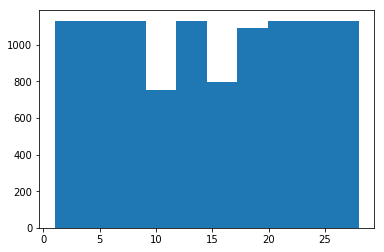

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]


TypeError: __init__() got an unexpected keyword argument 'num_classes'

In [130]:
bin_num_test2(dataset, n=28, epochs=20,tr_mask_length=200, val_mask_length=3000, test_mask_length=10556, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


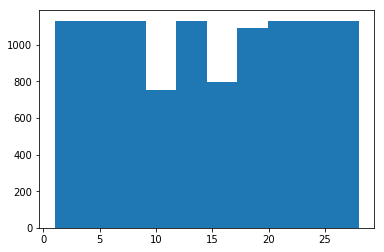

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


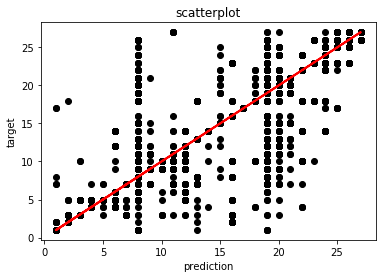

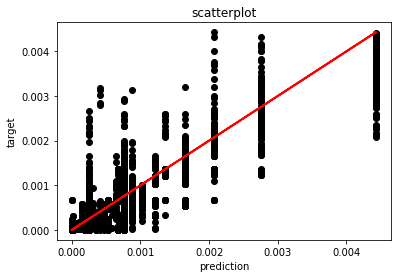

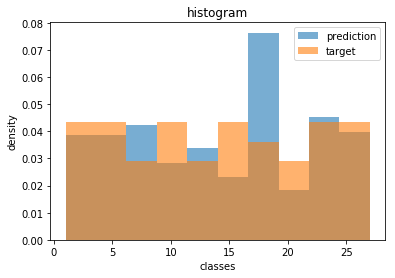

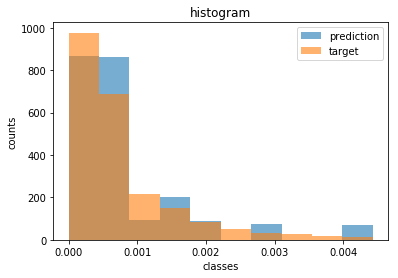

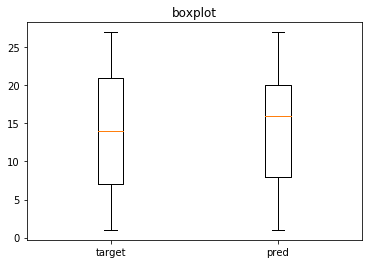

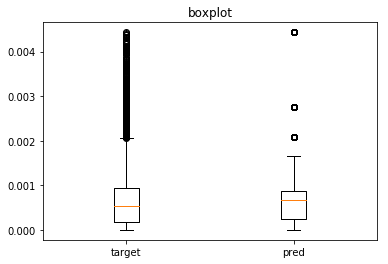

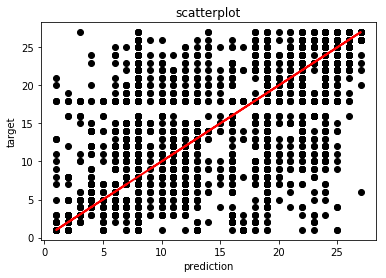

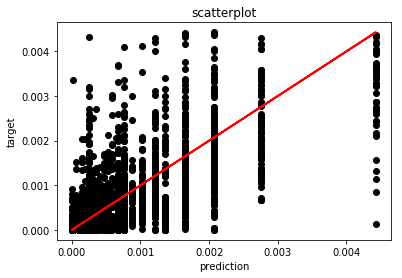

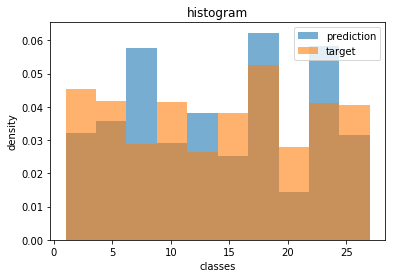

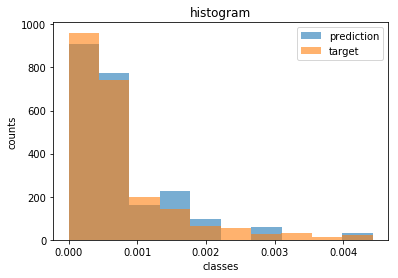

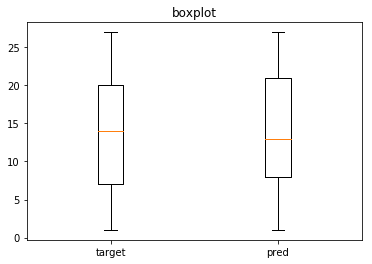

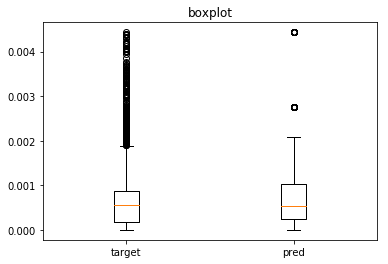

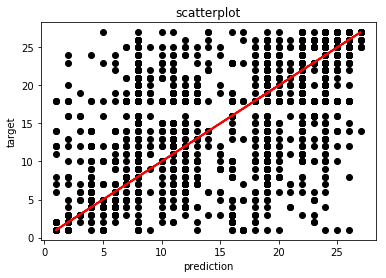

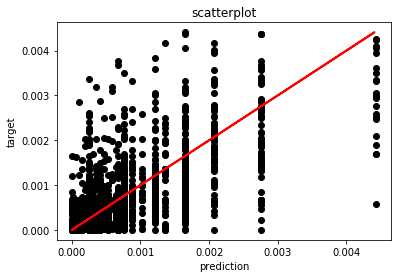

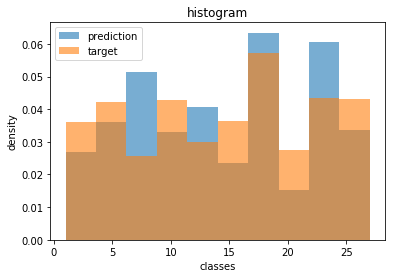

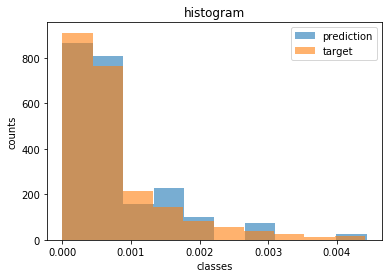

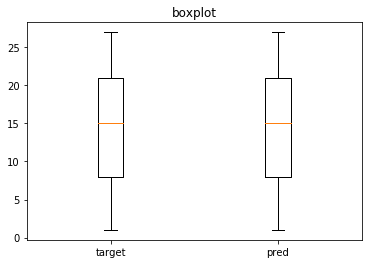

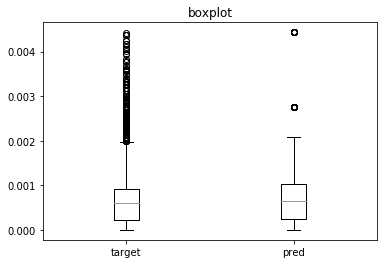

Val Loss: 3.3414, Test Accuracy: 0.219 ± 0.027, Test F1-macro: 0.208 ± 0.028, Duration: 5.430


In [123]:
bin_num_test2(dataset, n=28, epochs=250,tr_mask_length=200, val_mask_length=3000, test_mask_length=10556, results_file='GN_exp1_semisuperv-28bin2.csv')

tensor(0.0359)
array([-9.97272e-05,  4.86500e-07,  3.54100e-06,  1.99300e-05,
        5.76400e-05,  9.87600e-05,  1.49300e-04,  1.96400e-04,
        2.48300e-04,  3.02600e-04,  3.48300e-04,  4.14600e-04,
        4.74100e-04,  5.31100e-04,  5.88400e-04,  6.46800e-04,
        6.77400e-04,  6.77700e-04,  6.78400e-04,  7.62100e-04,
        8.77600e-04,  1.01900e-03,  1.20800e-03,  1.35500e-03,
        1.65300e-03,  2.07500e-03,  2.75100e-03,  4.43300e-03])
[[ 9]
 [ 9]
 [ 6]
 ...
 [20]
 [ 1]
 [ 7]]


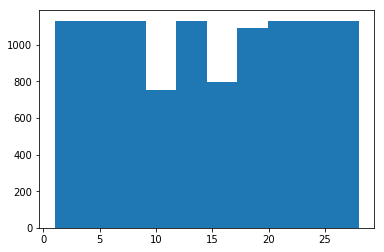

num_classes= 28 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[-9.97272e-05, 4.865e-07, 3.541e-06, 1.993e-05, 5.764e-05, 9.876e-05, 0.0001493, 0.0001964, 0.0002483, 0.0003026, 0.0003483, 0.0004146, 0.0004741, 0.0005311, 0.0005884, 0.0006468, 0.0006774, 0.0006777, 0.0006784, 0.0007621, 0.0008776, 0.001019, 0.001208, 0.001355, 0.001653, 0.002075, 0.002751, 0.004433]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([ 9,  9,  6,  ..., 20,  1,  7])


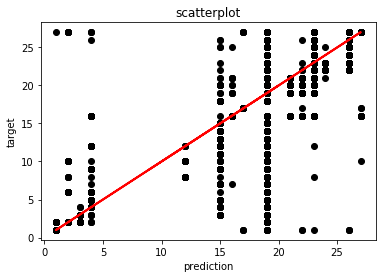

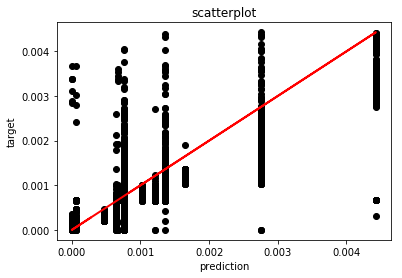

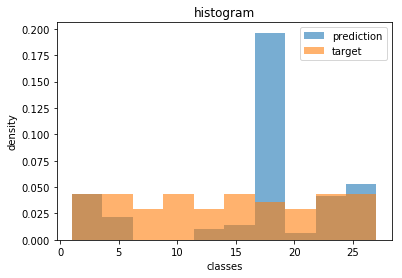

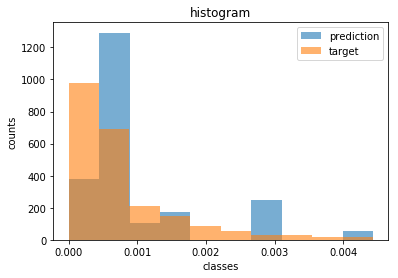

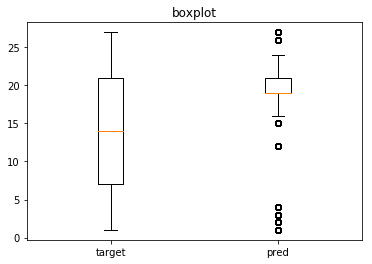

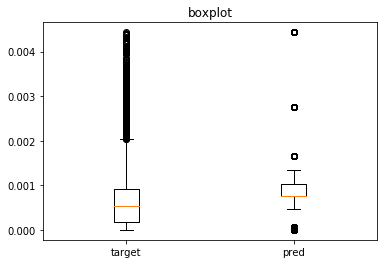

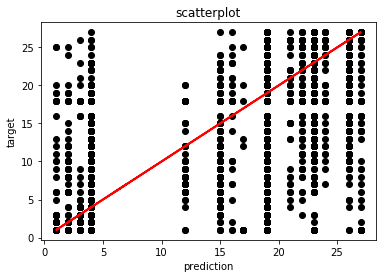

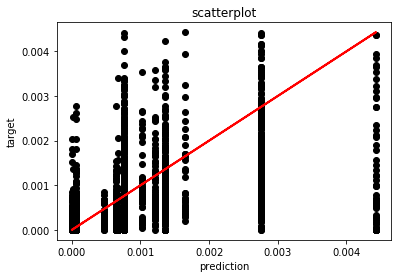

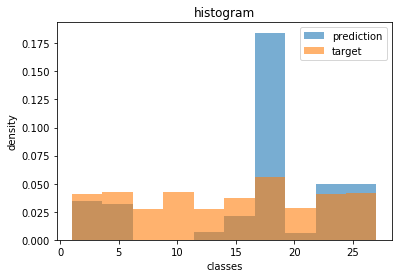

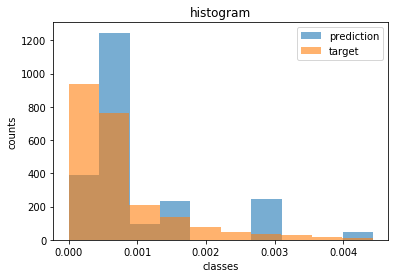

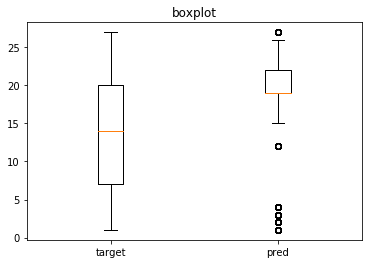

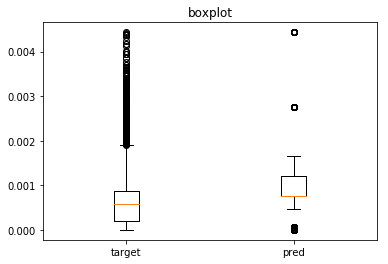

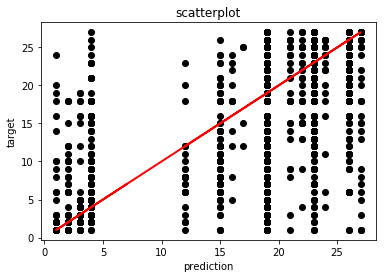

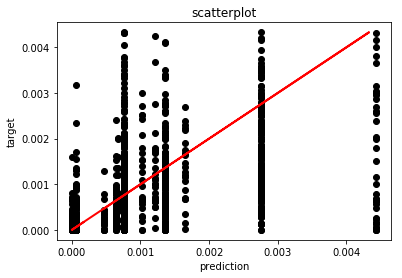

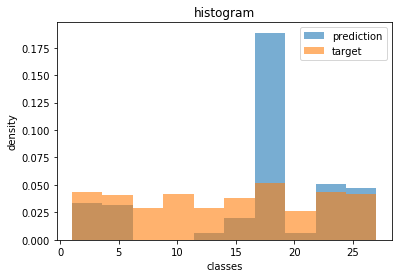

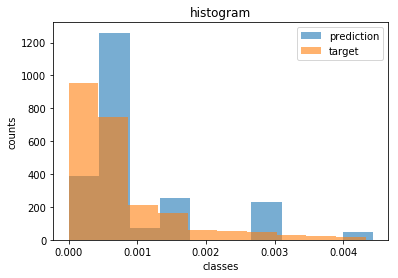

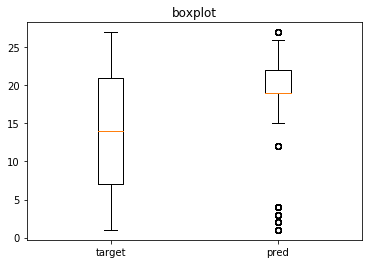

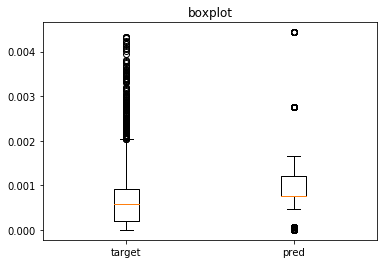

Val Loss: 3.7691, Test Accuracy: 0.142 ± 0.037, Test F1-macro: 0.124 ± 0.039, Duration: 12.673


In [124]:
bin_num_test2(dataset, n=28, epochs=600,tr_mask_length=200, val_mask_length=3000, test_mask_length=10556, results_file='GN_exp1_semisuperv-28bin2.csv')

In [129]:
reporting_from_csv_f1macro('GN_exp1_semisuperv-28bin2.csv',label='Experiment1-v2',title='Edge betweenness approximation with a graph neural network experiment')

Model  \
0  META1   
1  META1   
2  META1   
3  META1   
4  META1   
5  META1   
6  META1   
7  META1   

                                                                           Parameters  \
0    _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-100-2000-10556-   
1   _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=250_split-100-2000-10556-   
2       _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-1500-   
3      _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=250_split-20-500-1500-   
4    _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-200-3000-10556-   
5   _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=250_split-200-3000-10556-   
6   _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=600_split-200-3000-10556-   
7       _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=2_split-20-500-10556-   

     Loss        Accuracy        F1-macro  Time(min)  
0  2.3561   0.280 ± 0.061   0.251 ± 0.060      0.484  
1  3.8995   0.139 ± 0.018   0.128 ± 0.020      5.108  
2  3.0269   0.142 ± 0.027   0.127 ± 0.029      0.502  
3  4.9482   0.093 ± 0.013   0.087 ± 0.017      4.801  
4  2.0677   0.342 ± 0.078   0.312 ± 0.076      0.562  
5  3.3414   0.219 ± 0.027   0.208 ± 0.028      5.430  
6  3.7691   0.142 ± 0.037   0.124 ± 0.039     12.673  
7  3.0165   0.112 ± 0.047   0.088 ± 0.052      0.081

\begin{table}[H]
\centering
\begin{tabular}{llrllr}
\hline
 Model &                                                                          Paramteres  &  Runs\/Epochs  &  Splits &    Loss &        Accuracy &        F1-macro &  Time(min) \\
\hline
 META1 &     & d19d16h10e19n16n15 & 100-20 & 100-2000-10556- &  2.3561 &   0.280 ± 0.061 &   0.251 ± 0.060 &      0.484 \\
 META1 &    & d19d16h10e19n16n15 & 100-250 & 100-2000-10556- &  3.8995 &   0.139 ± 0.018 &   0.128 ± 0.020 &      5.108 \\
 META1 &        & d19d16h10e19n16n15 & 100-20 & 20-500-1500- &  3.0269 &   0.142 ± 0.027 &   0.127 ± 0.029 &      0.502 \\
 META1 &       & d19d16h10e19n16n15 & 100-250 & 20-500-1500- &  4.9482 &   0.093 ± 0.013 &   0.087 ± 0.017 &      4.801 \\
 META1 &     & d19d16h10e19n16n15 & 100-20 & 200-3000-10556- &  2.0677 &   0.342 ± 0.078 &   0.312 ± 0.076 &      0.562 \\
 META1 &    & d19d16h10e19n16n15 & 100-250 & 200-3000-10556- &  3.3414 &   0.219 ± 0.027 &   0.208 ± 0.028 &      5.430 \\
 META1 &    &

'\\begin{table}[H]\n\\centering\n\\begin{tabular}{llrllr}\n\\hline\n Model &                                                                          Paramteres  &  Runs\\/Epochs  &  Splits &    Loss &        Accuracy &        F1-macro &  Time(min) \\\\\n\\hline\n META1 &     & d19d16h10e19n16n15 & 100-20 & 100-2000-10556- &  2.3561 &   0.280 ± 0.061 &   0.251 ± 0.060 &      0.484 \\\\\n META1 &    & d19d16h10e19n16n15 & 100-250 & 100-2000-10556- &  3.8995 &   0.139 ± 0.018 &   0.128 ± 0.020 &      5.108 \\\\\n META1 &        & d19d16h10e19n16n15 & 100-20 & 20-500-1500- &  3.0269 &   0.142 ± 0.027 &   0.127 ± 0.029 &      0.502 \\\\\n META1 &       & d19d16h10e19n16n15 & 100-250 & 20-500-1500- &  4.9482 &   0.093 ± 0.013 &   0.087 ± 0.017 &      4.801 \\\\\n META1 &     & d19d16h10e19n16n15 & 100-20 & 200-3000-10556- &  2.0677 &   0.342 ± 0.078 &   0.312 ± 0.076 &      0.562 \\\\\n META1 &    & d19d16h10e19n16n15 & 100-250 & 200-3000-10556- &  3.3414 &   0.219 ± 0.027 &   0.208 ± 0.028

## 5 discrete ranges

tensor(0.0359)
array([-0.00099973,  0.000132  ,  0.000425  ,  0.000678  ,  0.00129   ])
[[2]
 [2]
 [2]
 ...
 [4]
 [1]
 [2]]


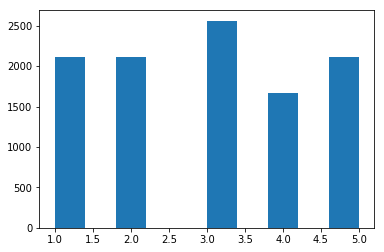

num_classes= 5 
 [1, 2, 3, 4, 5]
[-0.000999727, 0.000132, 0.000425, 0.000678, 0.00129]
RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
tensor([2, 2, 2,  ..., 4, 1, 2])


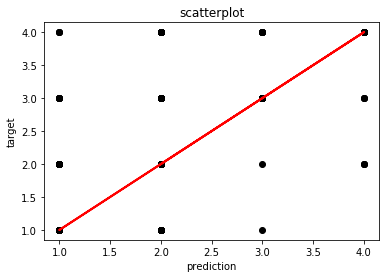

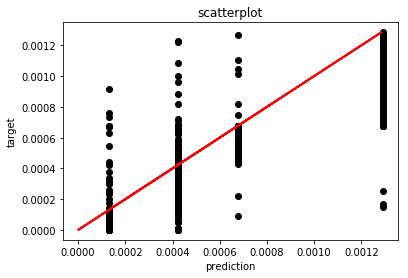

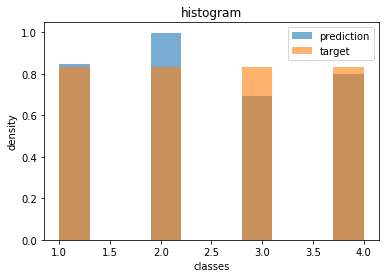

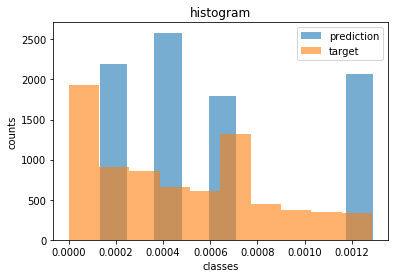

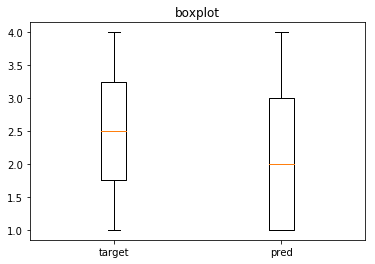

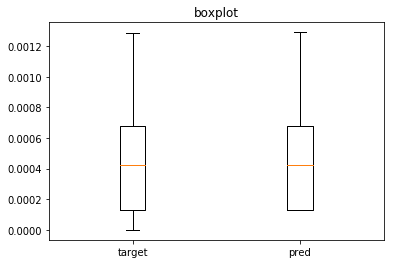

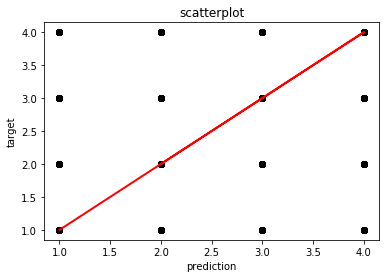

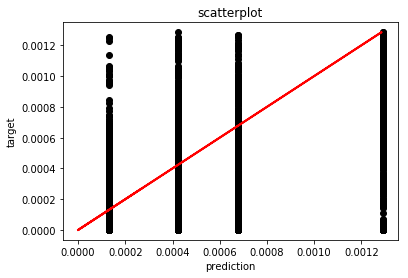

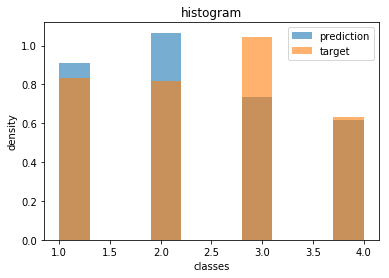

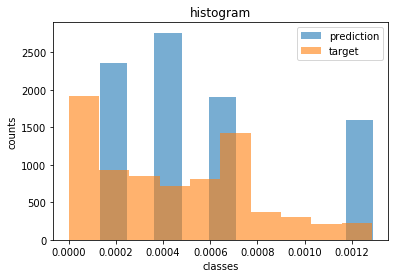

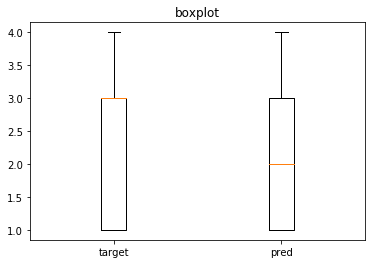

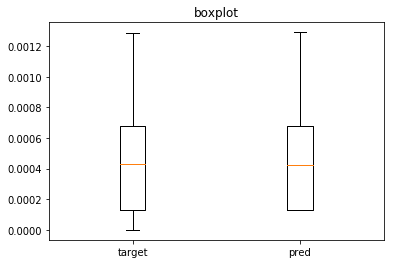

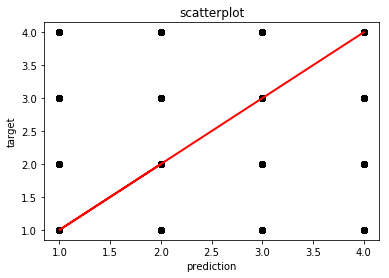

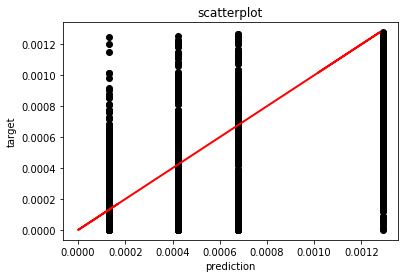

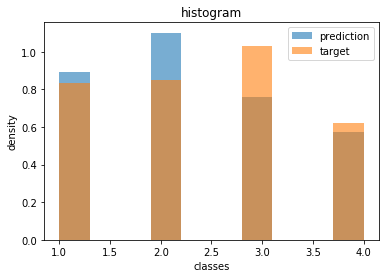

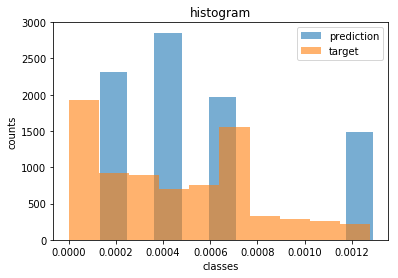

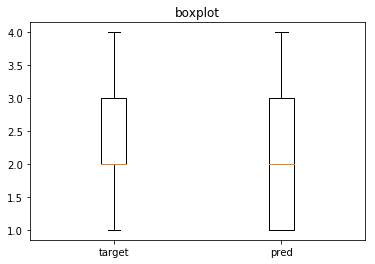

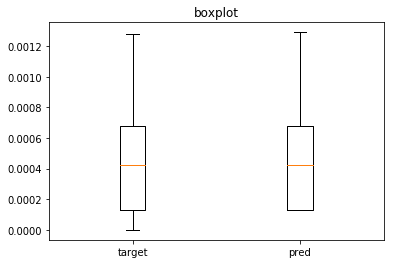

Val Loss: 0.9832, Test Accuracy: 0.621 ± 0.069, Duration: 0.408


In [40]:
bin_num_test2(dataset, n=5, epochs=20,tr_mask_length=300, val_mask_length=4000, test_mask_length=10556, results_file='GN_exp1_semisuperv-5bin.csv')

In [62]:
reporting_from_csv('GN_exp1_semisuperv-5bin.csv',label='Experiment1-v2',title='Edge betweenness approximation with a graph neural network experiment')

Model  \
0  META1   

                                                                          Parameters  \
0   _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-300-4000-10556-   

     Loss        Accuracy  Time(min)  
0  0.9832   0.621 ± 0.069      0.408

\begin{table}[H]
\centering
\begin{tabular}{|llllccc|}
\hline
 Model &                                                                         Paramteres  &  Runs\/Epochs  &  Splits &    Loss &        Accuracy &  Time(min) \\
\hline
 META1 &    & d19d16h10e19n16n15 & 100-20 & 300-4000-10556- &  0.9832 &   0.621 ± 0.069 &      0.408 \\
\hline
\end{tabular}
\label{Experiment1-v2}\caption{Edge betweenness approximation with a graph neural network experiment}
\end{table}


'\\begin{table}[H]\n\\centering\n\\begin{tabular}{|llllccc|}\n\\hline\n Model &                                                                         Paramteres  &  Runs\\/Epochs  &  Splits &    Loss &        Accuracy &  Time(min) \\\\\n\\hline\n META1 &    & d19d16h10e19n16n15 & 100-20 & 300-4000-10556- &  0.9832 &   0.621 ± 0.069 &      0.408 \\\\\n\\hline\n\\end{tabular}\n\\label{Experiment1-v2}\\caption{Edge betweenness approximation with a graph neural network experiment}\n\\end{table}'

## 3. Inductive setting quick test

Test trained model on another graph!

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import *
from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *
import os.path as osp

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

In [16]:
class MyOwnDataset2():
    def __init__(self,  root, name, transform=None, pre_transform=None):
        f = open(name, 'rb')
        self.data = pickle.load(f) 
        #print(self.data.num_features)
        self.num_features = self.data.num_features
        self.num_classes = 1
        f.close()
        

        
dname='../datasets/precomputed-pytorchg-betweenness_old/KarateClub_1_nd.pickle'
dataset2 = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)



In [ ]:
dir(dataset2.data)

In [18]:
print(dataset2.data.y.shape)
print(dataset2.data.x.shape)

torch.Size([34])
torch.Size([34, 1])


In [19]:
     
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask

In [20]:
def random_karate_splits(data, y, num_classes):
    indices = []
    for i in range(num_classes):
        index = (y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:2] for i in indices], dim=0)

    rest_index = torch.cat([i[2:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]
    
    data.train_edge_mask = index_to_mask(train_index, size=len(y))
    data.val_edge_mask = index_to_mask(rest_index[:7], size=len(y))
    data.test_edge_mask = index_to_mask(rest_index[7:], size=len(y))

    return data
        

[[3]
 [3]
 [5]
 [5]
 [2]
 [2]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [2]
 [2]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [3]
 [3]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [2]
 [2]
 [3]
 [3]
 [1]
 [1]
 [4]
 [4]
 [1]
 [1]
 [4]
 [4]
 [2]
 [2]
 [5]
 [5]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [3]
 [3]
 [3]
 [3]
 [1]
 [1]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [2]
 [2]
 [4]
 [4]
 [5]
 [5]
 [2]
 [2]
 [3]
 [3]
 [3]
 [3]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [2]
 [2]
 [3]
 [3]
 [1]
 [1]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [3]
 [3]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
num_classes= 3 
 [0, 1, 2]


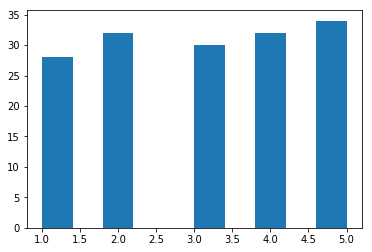

In [24]:
data2, y_discrete2, num_features2, num_classes2, num_edges2, num_edge_features2 = dataset_preprocessing(
    dataset2.data,
    thebins= [0.0,0.010,0.023,0.030, 0.0415],
    num_features=dataset2.num_features
)
permute_masks = random_karate_splits 
num_features = 1
num_classes = 5

In [25]:
data2

Data(edge_attr=[156, 1], edge_index=[2, 156], x=[34, 1], y=[156, 1])

In [26]:
def evaluate(model, data, y):
    
    
    model=model.to(device)
    data = data.to(device)
    y= y.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        edge_mask = data['{}_edge_mask'.format(key)]
        loss = F.nll_loss(logits[edge_mask], y[edge_mask]).item()
        pred = logits[edge_mask].max(1)[1]
        acc = pred.eq(y[edge_mask]).sum().item() / edge_mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

outs = evaluate(model,data2,y_discrete2)

NameError: name 'model' is not defined

In [13]:
dir(data2)

NameError: name 'data2' is not defined

## 4. NetworkX Girvan-Newman customization

Test trained model inside Girvan-Newman